In [1]:
!pip install m3_learning


  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Using cached pyUSID-0.0.10-py2.py3-none-any.whl (66 kB)
  Using cached sidpy-0.11-py2.py3-none-any.whl (96 kB)
  Obtaining dependency information for flatbuffers>=2.0 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: 

DEPRECATION: sidpy 0.11 has a non-standard dependency specifier distributed>=2.0.0psutil. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of sidpy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import time
import math

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.viz.layout import layout_fig
from m3_learning.viz.nn import embeddings, latent_generator
from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
from m3_learning.viz.nn import embeddings, latent_generator
set_style("printing")
random_seed(seed=42)

%matplotlib inline


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [3]:
class Sin_func:

    """
    Class that computes the Sin function
    """

    def __init__(
        self,
        x_vector,
        amp=[0, 1],
        phase=[0, 1],
        frequency=[0, 1],
        size=(1, 1),
        batch_size=1000,
        verbose=False,
    ):
        """

        Args:
            x_vector:
            sd (array, float): range for the standard deviation
            mean (array, float): range for the mean
            amp (array, float): range for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
        """

        self.x_vector = x_vector
        self.batch_size = batch_size

        self.amp = amp
        self.amp_mean = torch.tensor(amp[0] + amp[1]) / 2
        self.amp_sd = torch.sqrt(
            torch.pow(torch.tensor(amp[1]) - torch.tensor(amp[0]), 2) / 12
        )

        self.phase = phase
        self.phase_mean = torch.tensor(phase[0] + phase[1]) / 2
        self.phase_sd = torch.sqrt(
            torch.pow(torch.tensor(phase[1]) - torch.tensor(phase[0]), 2) / 12
        )

        self.frequency = frequency
        self.frequency_mean = torch.tensor(frequency[0] + frequency[1]) / 2
        self.frequency_sd = torch.sqrt(
            torch.pow(torch.tensor(frequency[1]) -
                      torch.tensor(frequency[0]), 2) / 12
        )

        self.size = size
        self.verbose = verbose

    def compute(self, params, device="cpu"):
        """

        Args:
            self (object): Returns the instance itself.
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: out (Tensor): spectra.

        """

        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x_vector.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _amp = params[:, 0, 0, i]
                _phase = params[:, 0, 1, i]
                _frequency = params[:, 0, 2, i]

            if params.ndim == 3:
                _amp = params[:, 0, i]
                _phase = params[:, 1, i]
                _frequency = params[:, 2, i]

            x_vector = (
                torch.cat(params.shape[0] * [self.x_vector])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x_vector = torch.transpose(x_vector, 0, 1)  # .to(device)

            _out = _amp * torch.sin(
                2 * torch.tensor(np.pi) * _frequency * x_vector + _phase
            )

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self, device="cpu"):
        """

        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        phase = rand_tensor(
            min=self.phase[0],
            max=self.phase[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        frequency = rand_tensor(
            min=self.frequency[0],
            max=self.frequency[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        amp = rand_tensor(
            min=self.amp[0],
            max=self.amp[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        _params = torch.torch.stack((amp, phase, frequency))

        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)

        return (self.compute(_params, device=device), _params)


In [4]:
constructor = Sin_func(
    amp=[0.2, 1],  # Sets the amplitude
    phase=[0, 2 * np.pi],  # Sets the phase
    frequency=[0.1, 0.5],  # Sets the frequency
    x_vector=torch.linspace(0, np.pi, 100),  # Sets the x_vector
    batch_size=10000,
)  # number of samples to generate


In [5]:
# initializes the constructor
output = constructor.sampler()

# grabs the parameters and the spectra
spectra, params = output

# This grabs the sum of all spectral and the individual spectra if they exist
spectra_full, spectras = spectra


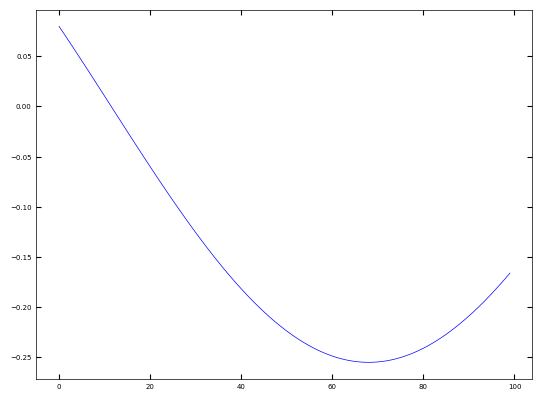

In [6]:
rand = np.random.randint(0, 10000)
plt.plot(spectras[rand, :, 0].cpu(), "b")


In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted


In [9]:
device = "cuda"
latent_dim = 3

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [10]:
# views the model

model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [11]:
# constructs a dataloader for training

dataloader = DataLoader(spectra_full, batch_size=512,
                        shuffle=True, num_workers=0)


In [12]:
# trains the model

random_seed(seed=42)

Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

  5%|████████████▊                                                                                                                                                                                                                                                   | 1/20 [00:01<00:19,  1.04s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 15/20 [00:01<00:00, 17.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.85it/s]

Epoch 0, Train Loss: 0.2216
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.12it/s]

Epoch 1, Train Loss: 0.2196
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.43it/s]

Epoch 2, Train Loss: 0.2179
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.69it/s]

Epoch 3, Train Loss: 0.2167
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.73it/s]

Epoch 4, Train Loss: 0.2155
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.99it/s]

Epoch 5, Train Loss: 0.2139
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.52it/s]

Epoch 6, Train Loss: 0.2130
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.40it/s]

Epoch 7, Train Loss: 0.2124
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.75it/s]

Epoch 8, Train Loss: 0.2115
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.71it/s]

Epoch 9, Train Loss: 0.2111
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 115.01it/s]

Epoch 10, Train Loss: 0.2103
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 114.88it/s]

Epoch 11, Train Loss: 0.2098
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 117.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.62it/s]

Epoch 12, Train Loss: 0.2097
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.81it/s]

Epoch 13, Train Loss: 0.2091
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 113.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 114.90it/s]

Epoch 14, Train Loss: 0.2087
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 114.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 114.54it/s]

Epoch 15, Train Loss: 0.2087
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.77it/s]

Epoch 16, Train Loss: 0.2086
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.18it/s]

Epoch 17, Train Loss: 0.2084
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.16it/s]

Epoch 18, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.81it/s]

Epoch 19, Train Loss: 0.2084
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.66it/s]

Epoch 20, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.48it/s]

Epoch 21, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.90it/s]

Epoch 22, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 120.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.08it/s]

Epoch 23, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.32it/s]

Epoch 24, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.00it/s]

Epoch 25, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.84it/s]

Epoch 26, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 119.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 108.76it/s]

Epoch 27, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 99.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 101.52it/s]

Epoch 28, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 107.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 112.77it/s]

Epoch 29, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.82it/s]

Epoch 30, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.38it/s]

Epoch 31, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.86it/s]

Epoch 32, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 113.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 114.14it/s]

Epoch 33, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 97.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.82it/s]

Epoch 34, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 98.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 35, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 111.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.04it/s]

Epoch 36, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 105.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 104.83it/s]

Epoch 37, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 109.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.32it/s]

Epoch 38, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 108.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 107.02it/s]

Epoch 39, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 109.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 110.18it/s]

Epoch 40, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 105.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 108.74it/s]

Epoch 41, Train Loss: 0.2074
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 113.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 111.12it/s]

Epoch 42, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 108.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 114.88it/s]

Epoch 43, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 91.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

Epoch 44, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 101.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 108.14it/s]

Epoch 45, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.18it/s]

Epoch 46, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 139.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.03it/s]

Epoch 47, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 144.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.10it/s]

Epoch 48, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.53it/s]

Epoch 49, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.58it/s]

Epoch 50, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.87it/s]

Epoch 51, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.88it/s]

Epoch 52, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.59it/s]

Epoch 53, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.55it/s]

Epoch 54, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.42it/s]

Epoch 55, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 147.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.98it/s]

Epoch 56, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.69it/s]

Epoch 57, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.89it/s]

Epoch 58, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.86it/s]

Epoch 59, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.87it/s]

Epoch 60, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.24it/s]

Epoch 61, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.53it/s]

Epoch 62, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.07it/s]

Epoch 63, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.75it/s]

Epoch 64, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.32it/s]

Epoch 65, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.12it/s]

Epoch 66, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.82it/s]

Epoch 67, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.20it/s]

Epoch 68, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.49it/s]

Epoch 69, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.34it/s]

Epoch 70, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.97it/s]

Epoch 71, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.73it/s]

Epoch 72, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.66it/s]

Epoch 73, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.65it/s]

Epoch 74, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.82it/s]

Epoch 75, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 112.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.79it/s]

Epoch 76, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.23it/s]

Epoch 77, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.32it/s]

Epoch 78, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.38it/s]

Epoch 79, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 128.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.25it/s]

Epoch 80, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.83it/s]

Epoch 81, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.86it/s]

Epoch 82, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.13it/s]

Epoch 83, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.72it/s]

Epoch 84, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.06it/s]

Epoch 85, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.04it/s]

Epoch 86, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.72it/s]

Epoch 87, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 143.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.54it/s]

Epoch 88, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.05it/s]

Epoch 89, Train Loss: 0.2074
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.82it/s]

Epoch 90, Train Loss: 0.2072
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.24it/s]

Epoch 91, Train Loss: 0.2070
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.05it/s]

Epoch 92, Train Loss: 0.2072
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.43it/s]

Epoch 93, Train Loss: 0.2068
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.56it/s]

Epoch 94, Train Loss: 0.2068
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.82it/s]

Epoch 95, Train Loss: 0.2069
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.44it/s]

Epoch 96, Train Loss: 0.2068
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.67it/s]

Epoch 97, Train Loss: 0.2069
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 108.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 104.69it/s]

Epoch 98, Train Loss: 0.2062
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.35it/s]

Epoch 99, Train Loss: 0.2060
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.40it/s]

Epoch 100, Train Loss: 0.2055
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.24it/s]

Epoch 101, Train Loss: 0.2061
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 114.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 113.58it/s]

Epoch 102, Train Loss: 0.2053
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 11/20 [00:00<00:00, 95.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 102.58it/s]

Epoch 103, Train Loss: 0.2055
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 114.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.14it/s]

Epoch 104, Train Loss: 0.2050
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.60it/s]

Epoch 105, Train Loss: 0.2044
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.06it/s]

Epoch 106, Train Loss: 0.2043
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.45it/s]

Epoch 107, Train Loss: 0.2039
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.82it/s]

Epoch 108, Train Loss: 0.2031
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.19it/s]

Epoch 109, Train Loss: 0.2027
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.10it/s]

Epoch 110, Train Loss: 0.2025
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.84it/s]

Epoch 111, Train Loss: 0.2021
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.17it/s]

Epoch 112, Train Loss: 0.2018
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.88it/s]

Epoch 113, Train Loss: 0.2012
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 145.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.19it/s]

Epoch 114, Train Loss: 0.2009
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.73it/s]

Epoch 115, Train Loss: 0.2003
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.99it/s]

Epoch 116, Train Loss: 0.2002
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.74it/s]

Epoch 117, Train Loss: 0.2000
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 144.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.33it/s]

Epoch 118, Train Loss: 0.1991
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.50it/s]

Epoch 119, Train Loss: 0.1990
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.49it/s]

Epoch 120, Train Loss: 0.1984
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 138.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.66it/s]

Epoch 121, Train Loss: 0.1984
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 144.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.18it/s]

Epoch 122, Train Loss: 0.1978
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.58it/s]

Epoch 123, Train Loss: 0.1979
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.07it/s]

Epoch 124, Train Loss: 0.1981
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.08it/s]

Epoch 125, Train Loss: 0.1976
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.67it/s]

Epoch 126, Train Loss: 0.1968
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.98it/s]

Epoch 127, Train Loss: 0.1947
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 147.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.38it/s]

Epoch 128, Train Loss: 0.1929
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.16it/s]

Epoch 129, Train Loss: 0.1916
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.87it/s]

Epoch 130, Train Loss: 0.1907
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.30it/s]

Epoch 131, Train Loss: 0.1898
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.13it/s]

Epoch 132, Train Loss: 0.1896
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.70it/s]

Epoch 133, Train Loss: 0.1897
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.23it/s]

Epoch 134, Train Loss: 0.1889
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.89it/s]

Epoch 135, Train Loss: 0.1890
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.19it/s]

Epoch 136, Train Loss: 0.1889
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.55it/s]

Epoch 137, Train Loss: 0.1891
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.29it/s]

Epoch 138, Train Loss: 0.1882
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.50it/s]

Epoch 139, Train Loss: 0.1887
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.22it/s]

Epoch 140, Train Loss: 0.1883
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.50it/s]

Epoch 141, Train Loss: 0.1880
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.35it/s]

Epoch 142, Train Loss: 0.1881
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.58it/s]

Epoch 143, Train Loss: 0.1878
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.08it/s]

Epoch 144, Train Loss: 0.1881
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.73it/s]

Epoch 145, Train Loss: 0.1874
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.11it/s]

Epoch 146, Train Loss: 0.1873
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.76it/s]

Epoch 147, Train Loss: 0.1872
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.74it/s]

Epoch 148, Train Loss: 0.1867
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.12it/s]

Epoch 149, Train Loss: 0.1864
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.17it/s]

Epoch 150, Train Loss: 0.1864
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.38it/s]

Epoch 151, Train Loss: 0.1861
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.27it/s]

Epoch 152, Train Loss: 0.1859
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.02it/s]

Epoch 153, Train Loss: 0.1859
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.83it/s]

Epoch 154, Train Loss: 0.1853
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.07it/s]

Epoch 155, Train Loss: 0.1853
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.72it/s]

Epoch 156, Train Loss: 0.1849
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.06it/s]

Epoch 157, Train Loss: 0.1845
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.45it/s]

Epoch 158, Train Loss: 0.1843
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.79it/s]

Epoch 159, Train Loss: 0.1844
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.67it/s]

Epoch 160, Train Loss: 0.1843
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.34it/s]

Epoch 161, Train Loss: 0.1839
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.03it/s]

Epoch 162, Train Loss: 0.1836
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 138.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.67it/s]

Epoch 163, Train Loss: 0.1832
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.43it/s]

Epoch 164, Train Loss: 0.1838
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.26it/s]

Epoch 165, Train Loss: 0.1834
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.20it/s]

Epoch 166, Train Loss: 0.1832
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.36it/s]

Epoch 167, Train Loss: 0.1827
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.36it/s]

Epoch 168, Train Loss: 0.1823
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.98it/s]

Epoch 169, Train Loss: 0.1826
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.02it/s]

Epoch 170, Train Loss: 0.1818
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.75it/s]

Epoch 171, Train Loss: 0.1821
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.18it/s]

Epoch 172, Train Loss: 0.1818
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.08it/s]

Epoch 173, Train Loss: 0.1816
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.18it/s]

Epoch 174, Train Loss: 0.1817
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.37it/s]

Epoch 175, Train Loss: 0.1818
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.59it/s]

Epoch 176, Train Loss: 0.1812
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.76it/s]

Epoch 177, Train Loss: 0.1812
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.01it/s]

Epoch 178, Train Loss: 0.1813
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.97it/s]

Epoch 179, Train Loss: 0.1811
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.91it/s]

Epoch 180, Train Loss: 0.1808
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.20it/s]

Epoch 181, Train Loss: 0.1809
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.89it/s]

Epoch 182, Train Loss: 0.1809
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.71it/s]

Epoch 183, Train Loss: 0.1806
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.89it/s]

Epoch 184, Train Loss: 0.1807
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.46it/s]

Epoch 185, Train Loss: 0.1805
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 114.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.37it/s]

Epoch 186, Train Loss: 0.1800
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.19it/s]

Epoch 187, Train Loss: 0.1800
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 114.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.93it/s]

Epoch 188, Train Loss: 0.1804
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.39it/s]

Epoch 189, Train Loss: 0.1797
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.67it/s]

Epoch 190, Train Loss: 0.1794
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.75it/s]

Epoch 191, Train Loss: 0.1796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.10it/s]

Epoch 192, Train Loss: 0.1794
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.25it/s]

Epoch 193, Train Loss: 0.1797
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 137.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.07it/s]

Epoch 194, Train Loss: 0.1793
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.71it/s]

Epoch 195, Train Loss: 0.1791
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.54it/s]

Epoch 196, Train Loss: 0.1795
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.20it/s]

Epoch 197, Train Loss: 0.1790
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.14it/s]

Epoch 198, Train Loss: 0.1792
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.14it/s]

Epoch 199, Train Loss: 0.1786
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.72it/s]

Epoch 200, Train Loss: 0.1788
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.86it/s]

Epoch 201, Train Loss: 0.1786
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 139.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.17it/s]

Epoch 202, Train Loss: 0.1786
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.39it/s]

Epoch 203, Train Loss: 0.1786
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.81it/s]

Epoch 204, Train Loss: 0.1784
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.29it/s]

Epoch 205, Train Loss: 0.1783
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.63it/s]

Epoch 206, Train Loss: 0.1785
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.75it/s]

Epoch 207, Train Loss: 0.1782
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.49it/s]

Epoch 208, Train Loss: 0.1782
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.73it/s]

Epoch 209, Train Loss: 0.1783
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.24it/s]

Epoch 210, Train Loss: 0.1781
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.77it/s]

Epoch 211, Train Loss: 0.1782
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.62it/s]

Epoch 212, Train Loss: 0.1783
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.43it/s]

Epoch 213, Train Loss: 0.1780
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.72it/s]

Epoch 214, Train Loss: 0.1780
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.30it/s]

Epoch 215, Train Loss: 0.1778
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.80it/s]

Epoch 216, Train Loss: 0.1776
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.34it/s]

Epoch 217, Train Loss: 0.1773
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.32it/s]

Epoch 218, Train Loss: 0.1772
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.97it/s]

Epoch 219, Train Loss: 0.1777
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.51it/s]

Epoch 220, Train Loss: 0.1775
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 147.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.09it/s]

Epoch 221, Train Loss: 0.1775
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 138.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.11it/s]

Epoch 222, Train Loss: 0.1770
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.90it/s]

Epoch 223, Train Loss: 0.1773
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.82it/s]

Epoch 224, Train Loss: 0.1774
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.34it/s]

Epoch 225, Train Loss: 0.1773
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.02it/s]

Epoch 226, Train Loss: 0.1770
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.60it/s]

Epoch 227, Train Loss: 0.1769
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.09it/s]

Epoch 228, Train Loss: 0.1768
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 144.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.69it/s]

Epoch 229, Train Loss: 0.1766
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.79it/s]

Epoch 230, Train Loss: 0.1764
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.23it/s]

Epoch 231, Train Loss: 0.1763
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 143.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.91it/s]

Epoch 232, Train Loss: 0.1761
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.16it/s]

Epoch 233, Train Loss: 0.1763
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.34it/s]

Epoch 234, Train Loss: 0.1761
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.14it/s]

Epoch 235, Train Loss: 0.1761
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.71it/s]

Epoch 236, Train Loss: 0.1756
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.30it/s]

Epoch 237, Train Loss: 0.1757
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.45it/s]

Epoch 238, Train Loss: 0.1755
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.90it/s]

Epoch 239, Train Loss: 0.1750
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.38it/s]

Epoch 240, Train Loss: 0.1751
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.26it/s]

Epoch 241, Train Loss: 0.1746
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.91it/s]

Epoch 242, Train Loss: 0.1742
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.06it/s]

Epoch 243, Train Loss: 0.1742
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.08it/s]

Epoch 244, Train Loss: 0.1732
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.69it/s]

Epoch 245, Train Loss: 0.1730
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.80it/s]

Epoch 246, Train Loss: 0.1720
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 137.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.22it/s]

Epoch 247, Train Loss: 0.1714
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.36it/s]

Epoch 248, Train Loss: 0.1705
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 143.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.95it/s]

Epoch 249, Train Loss: 0.1695
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.72it/s]

Epoch 250, Train Loss: 0.1682
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.70it/s]

Epoch 251, Train Loss: 0.1663
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.77it/s]

Epoch 252, Train Loss: 0.1647
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.03it/s]

Epoch 253, Train Loss: 0.1633
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.83it/s]

Epoch 254, Train Loss: 0.1619
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.95it/s]

Epoch 255, Train Loss: 0.1606
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.21it/s]

Epoch 256, Train Loss: 0.1599
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 138.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.53it/s]

Epoch 257, Train Loss: 0.1594
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.07it/s]

Epoch 258, Train Loss: 0.1588
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.41it/s]

Epoch 259, Train Loss: 0.1586
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.74it/s]

Epoch 260, Train Loss: 0.1579
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.78it/s]

Epoch 261, Train Loss: 0.1577
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.69it/s]

Epoch 262, Train Loss: 0.1572
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 128.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.03it/s]

Epoch 263, Train Loss: 0.1570
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.94it/s]

Epoch 264, Train Loss: 0.1564
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.02it/s]

Epoch 265, Train Loss: 0.1564
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.70it/s]

Epoch 266, Train Loss: 0.1560
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.81it/s]

Epoch 267, Train Loss: 0.1554
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.75it/s]

Epoch 268, Train Loss: 0.1554
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.17it/s]

Epoch 269, Train Loss: 0.1551
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.73it/s]

Epoch 270, Train Loss: 0.1547
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.88it/s]

Epoch 271, Train Loss: 0.1544
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.18it/s]

Epoch 272, Train Loss: 0.1542
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.13it/s]

Epoch 273, Train Loss: 0.1538
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.46it/s]

Epoch 274, Train Loss: 0.1539
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.77it/s]

Epoch 275, Train Loss: 0.1539
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.72it/s]

Epoch 276, Train Loss: 0.1530
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.16it/s]

Epoch 277, Train Loss: 0.1528
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.98it/s]

Epoch 278, Train Loss: 0.1529
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.37it/s]

Epoch 279, Train Loss: 0.1521
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 139.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.96it/s]

Epoch 280, Train Loss: 0.1518
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.82it/s]

Epoch 281, Train Loss: 0.1519
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.13it/s]

Epoch 282, Train Loss: 0.1510
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.73it/s]

Epoch 283, Train Loss: 0.1511
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.93it/s]

Epoch 284, Train Loss: 0.1510
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.94it/s]

Epoch 285, Train Loss: 0.1508
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 139.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.13it/s]

Epoch 286, Train Loss: 0.1504
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.25it/s]

Epoch 287, Train Loss: 0.1506
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.12it/s]

Epoch 288, Train Loss: 0.1499
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.77it/s]

Epoch 289, Train Loss: 0.1498
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.59it/s]

Epoch 290, Train Loss: 0.1494
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.13it/s]

Epoch 291, Train Loss: 0.1491
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.18it/s]

Epoch 292, Train Loss: 0.1488
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.95it/s]

Epoch 293, Train Loss: 0.1486
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.34it/s]

Epoch 294, Train Loss: 0.1484
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.16it/s]

Epoch 295, Train Loss: 0.1474
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.55it/s]

Epoch 296, Train Loss: 0.1479
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.90it/s]

Epoch 297, Train Loss: 0.1472
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.67it/s]

Epoch 298, Train Loss: 0.1472
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.36it/s]

Epoch 299, Train Loss: 0.1466
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.22it/s]

Epoch 300, Train Loss: 0.1464
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.30it/s]

Epoch 301, Train Loss: 0.1463
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.04it/s]

Epoch 302, Train Loss: 0.1462
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 115.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.25it/s]

Epoch 303, Train Loss: 0.1455
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.99it/s]

Epoch 304, Train Loss: 0.1455
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.66it/s]

Epoch 305, Train Loss: 0.1451
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.92it/s]

Epoch 306, Train Loss: 0.1446
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.75it/s]

Epoch 307, Train Loss: 0.1444
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.88it/s]

Epoch 308, Train Loss: 0.1441
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.36it/s]

Epoch 309, Train Loss: 0.1434
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.30it/s]

Epoch 310, Train Loss: 0.1434
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.34it/s]

Epoch 311, Train Loss: 0.1434
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.00it/s]

Epoch 312, Train Loss: 0.1430
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.24it/s]

Epoch 313, Train Loss: 0.1427
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.33it/s]

Epoch 314, Train Loss: 0.1422
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.47it/s]

Epoch 315, Train Loss: 0.1419
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.13it/s]

Epoch 316, Train Loss: 0.1415
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.23it/s]

Epoch 317, Train Loss: 0.1410
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.95it/s]

Epoch 318, Train Loss: 0.1410
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.23it/s]

Epoch 319, Train Loss: 0.1406
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.02it/s]

Epoch 320, Train Loss: 0.1399
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.45it/s]

Epoch 321, Train Loss: 0.1396
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.19it/s]

Epoch 322, Train Loss: 0.1392
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.16it/s]

Epoch 323, Train Loss: 0.1392
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.96it/s]

Epoch 324, Train Loss: 0.1386
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.45it/s]

Epoch 325, Train Loss: 0.1384
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.18it/s]

Epoch 326, Train Loss: 0.1377
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.25it/s]

Epoch 327, Train Loss: 0.1377
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.63it/s]

Epoch 328, Train Loss: 0.1370
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.86it/s]

Epoch 329, Train Loss: 0.1367
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.34it/s]

Epoch 330, Train Loss: 0.1364
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 120.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.96it/s]

Epoch 331, Train Loss: 0.1360
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.56it/s]

Epoch 332, Train Loss: 0.1354
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.96it/s]

Epoch 333, Train Loss: 0.1350
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.56it/s]

Epoch 334, Train Loss: 0.1345
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.79it/s]

Epoch 335, Train Loss: 0.1340
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.81it/s]

Epoch 336, Train Loss: 0.1336
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.59it/s]

Epoch 337, Train Loss: 0.1329
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.20it/s]

Epoch 338, Train Loss: 0.1326
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.26it/s]

Epoch 339, Train Loss: 0.1319
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.03it/s]

Epoch 340, Train Loss: 0.1317
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.68it/s]

Epoch 341, Train Loss: 0.1307
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.76it/s]

Epoch 342, Train Loss: 0.1305
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.44it/s]

Epoch 343, Train Loss: 0.1300
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.60it/s]

Epoch 344, Train Loss: 0.1298
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.67it/s]

Epoch 345, Train Loss: 0.1291
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.67it/s]

Epoch 346, Train Loss: 0.1287
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.33it/s]

Epoch 347, Train Loss: 0.1284
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.16it/s]

Epoch 348, Train Loss: 0.1278
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.03it/s]

Epoch 349, Train Loss: 0.1275
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.35it/s]

Epoch 350, Train Loss: 0.1274
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.12it/s]

Epoch 351, Train Loss: 0.1272
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.28it/s]

Epoch 352, Train Loss: 0.1274
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.31it/s]

Epoch 353, Train Loss: 0.1263
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.63it/s]

Epoch 354, Train Loss: 0.1263
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.31it/s]

Epoch 355, Train Loss: 0.1261
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.60it/s]

Epoch 356, Train Loss: 0.1253
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.33it/s]

Epoch 357, Train Loss: 0.1255
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.64it/s]

Epoch 358, Train Loss: 0.1252
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 114.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.35it/s]

Epoch 359, Train Loss: 0.1252
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 98.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.40it/s]

Epoch 360, Train Loss: 0.1248
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 8/20 [00:00<00:00, 71.70it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 16/20 [00:00<00:00, 62.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 65.58it/s]

Epoch 361, Train Loss: 0.1246
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 8/20 [00:00<00:00, 77.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 103.73it/s]

Epoch 362, Train Loss: 0.1242
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.57it/s]

Epoch 363, Train Loss: 0.1237
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.69it/s]

Epoch 364, Train Loss: 0.1242
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.08it/s]

Epoch 365, Train Loss: 0.1237
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.60it/s]

Epoch 366, Train Loss: 0.1231
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.80it/s]

Epoch 367, Train Loss: 0.1229
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.77it/s]

Epoch 368, Train Loss: 0.1233
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.09it/s]

Epoch 369, Train Loss: 0.1228
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.52it/s]

Epoch 370, Train Loss: 0.1222
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 115.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.75it/s]

Epoch 371, Train Loss: 0.1225
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.30it/s]

Epoch 372, Train Loss: 0.1221
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.59it/s]

Epoch 373, Train Loss: 0.1218
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.33it/s]

Epoch 374, Train Loss: 0.1216
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.64it/s]

Epoch 375, Train Loss: 0.1215
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.15it/s]

Epoch 376, Train Loss: 0.1213
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.74it/s]

Epoch 377, Train Loss: 0.1206
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.25it/s]

Epoch 378, Train Loss: 0.1207
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.08it/s]

Epoch 379, Train Loss: 0.1206
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.30it/s]

Epoch 380, Train Loss: 0.1205
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 102.17it/s]

Epoch 381, Train Loss: 0.1202
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.37it/s]

Epoch 382, Train Loss: 0.1203
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.51it/s]

Epoch 383, Train Loss: 0.1201
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.74it/s]

Epoch 384, Train Loss: 0.1198
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 117.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.51it/s]

Epoch 385, Train Loss: 0.1197
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 115.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 114.97it/s]

Epoch 386, Train Loss: 0.1198
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.29it/s]

Epoch 387, Train Loss: 0.1194
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.56it/s]

Epoch 388, Train Loss: 0.1188
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.56it/s]

Epoch 389, Train Loss: 0.1189
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.61it/s]

Epoch 390, Train Loss: 0.1186
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.85it/s]

Epoch 391, Train Loss: 0.1185
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.98it/s]

Epoch 392, Train Loss: 0.1182
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.58it/s]

Epoch 393, Train Loss: 0.1181
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.26it/s]

Epoch 394, Train Loss: 0.1179
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.73it/s]

Epoch 395, Train Loss: 0.1177
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.81it/s]

Epoch 396, Train Loss: 0.1179
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.52it/s]

Epoch 397, Train Loss: 0.1176
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.17it/s]

Epoch 398, Train Loss: 0.1175
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 139.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.96it/s]

Epoch 399, Train Loss: 0.1170
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.95it/s]

Epoch 400, Train Loss: 0.1170
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.04it/s]

Epoch 401, Train Loss: 0.1167
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.55it/s]

Epoch 402, Train Loss: 0.1167
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 140.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.18it/s]

Epoch 403, Train Loss: 0.1166
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.46it/s]

Epoch 404, Train Loss: 0.1162
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.64it/s]

Epoch 405, Train Loss: 0.1165
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.52it/s]

Epoch 406, Train Loss: 0.1161
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.10it/s]

Epoch 407, Train Loss: 0.1157
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.21it/s]

Epoch 408, Train Loss: 0.1157
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.34it/s]

Epoch 409, Train Loss: 0.1154
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.66it/s]

Epoch 410, Train Loss: 0.1152
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.97it/s]

Epoch 411, Train Loss: 0.1151
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.38it/s]

Epoch 412, Train Loss: 0.1150
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 9/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.11it/s]

Epoch 413, Train Loss: 0.1148
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.92it/s]

Epoch 414, Train Loss: 0.1143
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 103.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 107.88it/s]

Epoch 415, Train Loss: 0.1142
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 108.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 113.02it/s]

Epoch 416, Train Loss: 0.1140
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.25it/s]

Epoch 417, Train Loss: 0.1138
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.35it/s]

Epoch 418, Train Loss: 0.1139
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.05it/s]

Epoch 419, Train Loss: 0.1133
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.41it/s]

Epoch 420, Train Loss: 0.1133
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.40it/s]

Epoch 421, Train Loss: 0.1132
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 113.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.28it/s]

Epoch 422, Train Loss: 0.1130
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.10it/s]

Epoch 423, Train Loss: 0.1128
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.68it/s]

Epoch 424, Train Loss: 0.1130
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.54it/s]

Epoch 425, Train Loss: 0.1125
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.33it/s]

Epoch 426, Train Loss: 0.1123
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.45it/s]

Epoch 427, Train Loss: 0.1119
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.66it/s]

Epoch 428, Train Loss: 0.1120
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.82it/s]

Epoch 429, Train Loss: 0.1115
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.52it/s]

Epoch 430, Train Loss: 0.1116
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.03it/s]

Epoch 431, Train Loss: 0.1113
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.94it/s]

Epoch 432, Train Loss: 0.1111
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.63it/s]

Epoch 433, Train Loss: 0.1110
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 109.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.68it/s]

Epoch 434, Train Loss: 0.1102
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 88.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.50it/s]

Epoch 435, Train Loss: 0.1102
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.70it/s]

Epoch 436, Train Loss: 0.1100
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 108.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 110.04it/s]

Epoch 437, Train Loss: 0.1095
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 107.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.95it/s]

Epoch 438, Train Loss: 0.1090
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 97.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.42it/s]

Epoch 439, Train Loss: 0.1095
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 113.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.98it/s]

Epoch 440, Train Loss: 0.1091
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.99it/s]

Epoch 441, Train Loss: 0.1086
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.18it/s]

Epoch 442, Train Loss: 0.1087
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 94.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.50it/s]

Epoch 443, Train Loss: 0.1082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 115.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.07it/s]

Epoch 444, Train Loss: 0.1087
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.30it/s]

Epoch 445, Train Loss: 0.1078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.05it/s]

Epoch 446, Train Loss: 0.1073
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 120.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.37it/s]

Epoch 447, Train Loss: 0.1074
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.97it/s]

Epoch 448, Train Loss: 0.1068
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 108.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 104.92it/s]

Epoch 449, Train Loss: 0.1062
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.39it/s]

Epoch 450, Train Loss: 0.1059
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.26it/s]

Epoch 451, Train Loss: 0.1056
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.26it/s]

Epoch 452, Train Loss: 0.1053
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.81it/s]

Epoch 453, Train Loss: 0.1052
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.43it/s]

Epoch 454, Train Loss: 0.1050
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.13it/s]

Epoch 455, Train Loss: 0.1042
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.97it/s]

Epoch 456, Train Loss: 0.1037
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.37it/s]

Epoch 457, Train Loss: 0.1036
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.25it/s]

Epoch 458, Train Loss: 0.1028
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.12it/s]

Epoch 459, Train Loss: 0.1022
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.48it/s]

Epoch 460, Train Loss: 0.1019
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.69it/s]

Epoch 461, Train Loss: 0.1016
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.84it/s]

Epoch 462, Train Loss: 0.1009
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.68it/s]

Epoch 463, Train Loss: 0.1002
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.52it/s]

Epoch 464, Train Loss: 0.1002
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.06it/s]

Epoch 465, Train Loss: 0.0992
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.31it/s]

Epoch 466, Train Loss: 0.0987
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.13it/s]

Epoch 467, Train Loss: 0.0983
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.46it/s]

Epoch 468, Train Loss: 0.0980
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.94it/s]

Epoch 469, Train Loss: 0.0971
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.73it/s]

Epoch 470, Train Loss: 0.0968
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.19it/s]

Epoch 471, Train Loss: 0.0955
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.54it/s]

Epoch 472, Train Loss: 0.0953
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.00it/s]

Epoch 473, Train Loss: 0.0946
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.09it/s]

Epoch 474, Train Loss: 0.0939
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.92it/s]

Epoch 475, Train Loss: 0.0937
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.78it/s]

Epoch 476, Train Loss: 0.0933
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.16it/s]

Epoch 477, Train Loss: 0.0929
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.63it/s]

Epoch 478, Train Loss: 0.0920
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.64it/s]

Epoch 479, Train Loss: 0.0922
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 108.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 115.38it/s]

Epoch 480, Train Loss: 0.0912
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.05it/s]

Epoch 481, Train Loss: 0.0906
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.33it/s]

Epoch 482, Train Loss: 0.0902
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.12it/s]

Epoch 483, Train Loss: 0.0901
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.32it/s]

Epoch 484, Train Loss: 0.0894
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.66it/s]

Epoch 485, Train Loss: 0.0890
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.99it/s]

Epoch 486, Train Loss: 0.0887
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.63it/s]

Epoch 487, Train Loss: 0.0882
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.47it/s]

Epoch 488, Train Loss: 0.0880
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.53it/s]

Epoch 489, Train Loss: 0.0874
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.20it/s]

Epoch 490, Train Loss: 0.0876
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.86it/s]

Epoch 491, Train Loss: 0.0868
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.51it/s]

Epoch 492, Train Loss: 0.0867
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 128.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.33it/s]

Epoch 493, Train Loss: 0.0861
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.62it/s]

Epoch 494, Train Loss: 0.0857
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.91it/s]

Epoch 495, Train Loss: 0.0857
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.77it/s]

Epoch 496, Train Loss: 0.0853
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.18it/s]

Epoch 497, Train Loss: 0.0850
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.01it/s]

Epoch 498, Train Loss: 0.0847
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 139.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.22it/s]

Epoch 499, Train Loss: 0.0847
.............................


In [13]:
# computes an example reconstruction for a mini batch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


C:\Conda\envs\tester\lib\site-packages\m3_learning\nn\time_series_nn\nn_util.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))


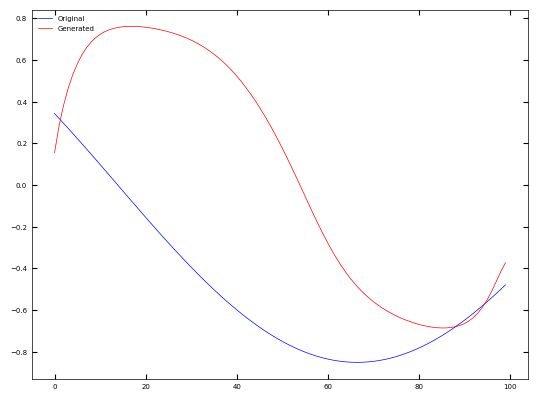

In [14]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


In [15]:
# Loads dog image

image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image

image = image[200:1900:20, 100:1500:20] / 255


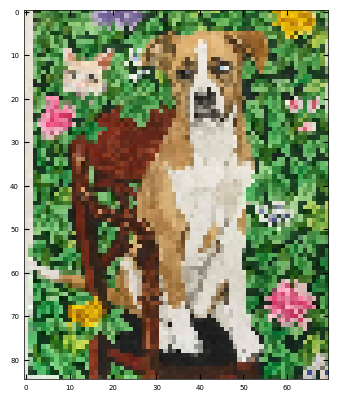

In [16]:
plt.imshow(image)


In [17]:
# Converts the image into parameters within the generated range

nala_params = np.atleast_3d(image.reshape(-1, 3))

nala_amp = torch.tensor(nala_params[:, 0, 0] * 0.8 + 0.2)
nala_phase = torch.tensor(nala_params[:, 1, 0] * 2 * np.pi)
nala_frequency = torch.tensor(nala_params[:, 2, 0] * 0.5 + 0.1)

_nala_params = torch.torch.stack((nala_amp, nala_phase, nala_frequency))

_nala_params = torch.atleast_3d(_nala_params)
_nala_params = torch.transpose(_nala_params, 0, 1)


In [18]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


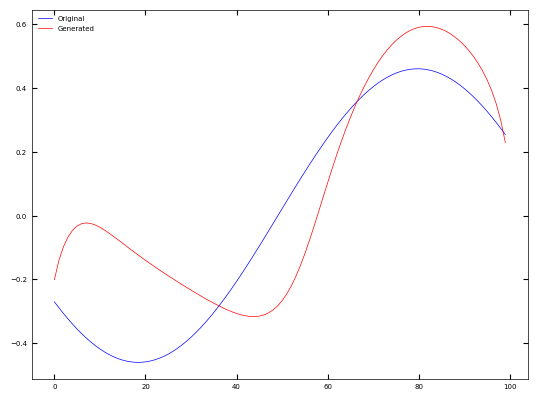

In [19]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


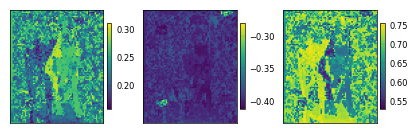

In [20]:
# Visualize the learned embeddings
embeddings(nala_encoded_, shape_=image.shape[0:2], figsize=(5, 1.25))


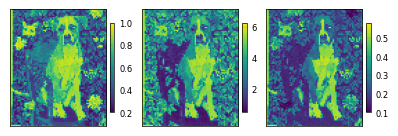

In [21]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))


In [22]:
device = "cuda"
latent_dim = 12

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [23]:
# views the model

model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [24]:
# trains the model

torch.manual_seed(0)
Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.41it/s]

Epoch 0, Train Loss: 0.2270
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.16it/s]

Epoch 1, Train Loss: 0.2245
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.87it/s]

Epoch 2, Train Loss: 0.2225
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.64it/s]

Epoch 3, Train Loss: 0.2203
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.49it/s]

Epoch 4, Train Loss: 0.2191
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.21it/s]

Epoch 5, Train Loss: 0.2170
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.28it/s]

Epoch 6, Train Loss: 0.2159
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 8/20 [00:00<00:00, 79.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 103.33it/s]

Epoch 7, Train Loss: 0.2144
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.03it/s]

Epoch 8, Train Loss: 0.2135
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.29it/s]

Epoch 9, Train Loss: 0.2126
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.49it/s]

Epoch 10, Train Loss: 0.2119
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.10it/s]

Epoch 11, Train Loss: 0.2113
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.98it/s]

Epoch 12, Train Loss: 0.2105
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 94.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 103.66it/s]

Epoch 13, Train Loss: 0.2097
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.18it/s]

Epoch 14, Train Loss: 0.2093
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.38it/s]

Epoch 15, Train Loss: 0.2086
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.26it/s]

Epoch 16, Train Loss: 0.2088
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.32it/s]

Epoch 17, Train Loss: 0.2086
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.87it/s]

Epoch 18, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.13it/s]

Epoch 19, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.56it/s]

Epoch 20, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.21it/s]

Epoch 21, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.65it/s]

Epoch 22, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.07it/s]

Epoch 23, Train Loss: 0.2085
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.05it/s]

Epoch 24, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.61it/s]

Epoch 25, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.20it/s]

Epoch 26, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.06it/s]

Epoch 27, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.75it/s]

Epoch 28, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.93it/s]

Epoch 29, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.08it/s]

Epoch 30, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.96it/s]

Epoch 31, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 142.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.57it/s]

Epoch 32, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.85it/s]

Epoch 33, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.38it/s]

Epoch 34, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.29it/s]

Epoch 35, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.90it/s]

Epoch 36, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.75it/s]

Epoch 37, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.11it/s]

Epoch 38, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.08it/s]

Epoch 39, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.35it/s]

Epoch 40, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.00it/s]

Epoch 41, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.66it/s]

Epoch 42, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.06it/s]

Epoch 43, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.20it/s]

Epoch 44, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.36it/s]

Epoch 45, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.94it/s]

Epoch 46, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.96it/s]

Epoch 47, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.14it/s]

Epoch 48, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.30it/s]

Epoch 49, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.72it/s]

Epoch 50, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.03it/s]

Epoch 51, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.24it/s]

Epoch 52, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.88it/s]

Epoch 53, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 15/20 [00:00<00:00, 141.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.91it/s]

Epoch 54, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.59it/s]

Epoch 55, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.81it/s]

Epoch 56, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.17it/s]

Epoch 57, Train Loss: 0.2077
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.35it/s]

Epoch 58, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.25it/s]

Epoch 59, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.43it/s]

Epoch 60, Train Loss: 0.2082
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.58it/s]

Epoch 61, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.41it/s]

Epoch 62, Train Loss: 0.2081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.03it/s]

Epoch 63, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.49it/s]

Epoch 64, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 138.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.02it/s]

Epoch 65, Train Loss: 0.2079
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.28it/s]

Epoch 66, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 128.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.34it/s]

Epoch 67, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.35it/s]

Epoch 68, Train Loss: 0.2075
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.58it/s]

Epoch 69, Train Loss: 0.2074
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.50it/s]

Epoch 70, Train Loss: 0.2073
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.66it/s]

Epoch 71, Train Loss: 0.2071
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.71it/s]

Epoch 72, Train Loss: 0.2073
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.63it/s]

Epoch 73, Train Loss: 0.2067
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.13it/s]

Epoch 74, Train Loss: 0.2066
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.83it/s]

Epoch 75, Train Loss: 0.2066
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.66it/s]

Epoch 76, Train Loss: 0.2065
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.34it/s]

Epoch 77, Train Loss: 0.2061
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.11it/s]

Epoch 78, Train Loss: 0.2059
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.37it/s]

Epoch 79, Train Loss: 0.2053
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.63it/s]

Epoch 80, Train Loss: 0.2048
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.86it/s]

Epoch 81, Train Loss: 0.2049
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.07it/s]

Epoch 82, Train Loss: 0.2040
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.53it/s]

Epoch 83, Train Loss: 0.2034
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.69it/s]

Epoch 84, Train Loss: 0.2022
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.60it/s]

Epoch 85, Train Loss: 0.2006
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.88it/s]

Epoch 86, Train Loss: 0.1996
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.86it/s]

Epoch 87, Train Loss: 0.1986
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.54it/s]

Epoch 88, Train Loss: 0.1978
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.89it/s]

Epoch 89, Train Loss: 0.1970
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.31it/s]

Epoch 90, Train Loss: 0.1966
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.89it/s]

Epoch 91, Train Loss: 0.1964
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.08it/s]

Epoch 92, Train Loss: 0.1951
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.51it/s]

Epoch 93, Train Loss: 0.1943
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.33it/s]

Epoch 94, Train Loss: 0.1929
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.27it/s]

Epoch 95, Train Loss: 0.1923
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.61it/s]

Epoch 96, Train Loss: 0.1913
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.43it/s]

Epoch 97, Train Loss: 0.1906
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.63it/s]

Epoch 98, Train Loss: 0.1903
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.17it/s]

Epoch 99, Train Loss: 0.1901
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.81it/s]

Epoch 100, Train Loss: 0.1900
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.77it/s]

Epoch 101, Train Loss: 0.1900
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.70it/s]

Epoch 102, Train Loss: 0.1894
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.95it/s]

Epoch 103, Train Loss: 0.1897
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.84it/s]

Epoch 104, Train Loss: 0.1885
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.93it/s]

Epoch 105, Train Loss: 0.1888
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.90it/s]

Epoch 106, Train Loss: 0.1885
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 117.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.87it/s]

Epoch 107, Train Loss: 0.1881
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.03it/s]

Epoch 108, Train Loss: 0.1876
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.79it/s]

Epoch 109, Train Loss: 0.1876
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.67it/s]

Epoch 110, Train Loss: 0.1871
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.77it/s]

Epoch 111, Train Loss: 0.1865
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.22it/s]

Epoch 112, Train Loss: 0.1864
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.17it/s]

Epoch 113, Train Loss: 0.1865
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.43it/s]

Epoch 114, Train Loss: 0.1859
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.00it/s]

Epoch 115, Train Loss: 0.1850
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.94it/s]

Epoch 116, Train Loss: 0.1847
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 119.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.70it/s]

Epoch 117, Train Loss: 0.1846
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.66it/s]

Epoch 118, Train Loss: 0.1840
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.43it/s]

Epoch 119, Train Loss: 0.1832
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.49it/s]

Epoch 120, Train Loss: 0.1830
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.86it/s]

Epoch 121, Train Loss: 0.1824
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.42it/s]

Epoch 122, Train Loss: 0.1821
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.47it/s]

Epoch 123, Train Loss: 0.1817
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.23it/s]

Epoch 124, Train Loss: 0.1818
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.48it/s]

Epoch 125, Train Loss: 0.1812
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 118.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.38it/s]

Epoch 126, Train Loss: 0.1808
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.61it/s]

Epoch 127, Train Loss: 0.1807
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.37it/s]

Epoch 128, Train Loss: 0.1806
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.23it/s]

Epoch 129, Train Loss: 0.1801
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.41it/s]

Epoch 130, Train Loss: 0.1798
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.24it/s]

Epoch 131, Train Loss: 0.1796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.87it/s]

Epoch 132, Train Loss: 0.1793
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.83it/s]

Epoch 133, Train Loss: 0.1790
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.73it/s]

Epoch 134, Train Loss: 0.1788
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.60it/s]

Epoch 135, Train Loss: 0.1783
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.62it/s]

Epoch 136, Train Loss: 0.1785
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 115.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.11it/s]

Epoch 137, Train Loss: 0.1780
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 127.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.14it/s]

Epoch 138, Train Loss: 0.1778
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.90it/s]

Epoch 139, Train Loss: 0.1772
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.84it/s]

Epoch 140, Train Loss: 0.1765
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.67it/s]

Epoch 141, Train Loss: 0.1765
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.13it/s]

Epoch 142, Train Loss: 0.1763
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.37it/s]

Epoch 143, Train Loss: 0.1748
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.26it/s]

Epoch 144, Train Loss: 0.1749
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.54it/s]

Epoch 145, Train Loss: 0.1736
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.55it/s]

Epoch 146, Train Loss: 0.1728
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.84it/s]

Epoch 147, Train Loss: 0.1715
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.16it/s]

Epoch 148, Train Loss: 0.1703
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.10it/s]

Epoch 149, Train Loss: 0.1680
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.06it/s]

Epoch 150, Train Loss: 0.1657
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.25it/s]

Epoch 151, Train Loss: 0.1644
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.45it/s]

Epoch 152, Train Loss: 0.1617
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.09it/s]

Epoch 153, Train Loss: 0.1598
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.92it/s]

Epoch 154, Train Loss: 0.1584
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.67it/s]

Epoch 155, Train Loss: 0.1565
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.42it/s]

Epoch 156, Train Loss: 0.1546
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.16it/s]

Epoch 157, Train Loss: 0.1537
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.95it/s]

Epoch 158, Train Loss: 0.1529
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 128.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.08it/s]

Epoch 159, Train Loss: 0.1519
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.53it/s]

Epoch 160, Train Loss: 0.1508
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.24it/s]

Epoch 161, Train Loss: 0.1496
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.55it/s]

Epoch 162, Train Loss: 0.1488
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.88it/s]

Epoch 163, Train Loss: 0.1480
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.43it/s]

Epoch 164, Train Loss: 0.1477
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.70it/s]

Epoch 165, Train Loss: 0.1483
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.69it/s]

Epoch 166, Train Loss: 0.1464
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.08it/s]

Epoch 167, Train Loss: 0.1460
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.09it/s]

Epoch 168, Train Loss: 0.1456
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.22it/s]

Epoch 169, Train Loss: 0.1449
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.50it/s]

Epoch 170, Train Loss: 0.1452
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.40it/s]

Epoch 171, Train Loss: 0.1445
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.68it/s]

Epoch 172, Train Loss: 0.1442
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.87it/s]

Epoch 173, Train Loss: 0.1440
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.76it/s]

Epoch 174, Train Loss: 0.1433
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.22it/s]

Epoch 175, Train Loss: 0.1437
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.42it/s]

Epoch 176, Train Loss: 0.1436
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.53it/s]

Epoch 177, Train Loss: 0.1432
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.29it/s]

Epoch 178, Train Loss: 0.1426
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.53it/s]

Epoch 179, Train Loss: 0.1425
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.37it/s]

Epoch 180, Train Loss: 0.1422
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.09it/s]

Epoch 181, Train Loss: 0.1424
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.65it/s]

Epoch 182, Train Loss: 0.1424
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.92it/s]

Epoch 183, Train Loss: 0.1423
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.36it/s]

Epoch 184, Train Loss: 0.1419
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.53it/s]

Epoch 185, Train Loss: 0.1415
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.31it/s]

Epoch 186, Train Loss: 0.1410
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.97it/s]

Epoch 187, Train Loss: 0.1409
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.38it/s]

Epoch 188, Train Loss: 0.1409
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.81it/s]

Epoch 189, Train Loss: 0.1406
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.61it/s]

Epoch 190, Train Loss: 0.1404
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.35it/s]

Epoch 191, Train Loss: 0.1399
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.28it/s]

Epoch 192, Train Loss: 0.1401
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.71it/s]

Epoch 193, Train Loss: 0.1401
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 120.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.24it/s]

Epoch 194, Train Loss: 0.1401
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.15it/s]

Epoch 195, Train Loss: 0.1395
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.50it/s]

Epoch 196, Train Loss: 0.1393
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.98it/s]

Epoch 197, Train Loss: 0.1391
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.21it/s]

Epoch 198, Train Loss: 0.1391
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.22it/s]

Epoch 199, Train Loss: 0.1391
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.16it/s]

Epoch 200, Train Loss: 0.1391
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.75it/s]

Epoch 201, Train Loss: 0.1387
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 128.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.17it/s]

Epoch 202, Train Loss: 0.1385
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.92it/s]

Epoch 203, Train Loss: 0.1381
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.80it/s]

Epoch 204, Train Loss: 0.1383
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.52it/s]

Epoch 205, Train Loss: 0.1379
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.27it/s]

Epoch 206, Train Loss: 0.1375
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.14it/s]

Epoch 207, Train Loss: 0.1376
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.72it/s]

Epoch 208, Train Loss: 0.1375
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.00it/s]

Epoch 209, Train Loss: 0.1375
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.44it/s]

Epoch 210, Train Loss: 0.1371
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.62it/s]

Epoch 211, Train Loss: 0.1368
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.18it/s]

Epoch 212, Train Loss: 0.1365
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.48it/s]

Epoch 213, Train Loss: 0.1364
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.98it/s]

Epoch 214, Train Loss: 0.1367
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.83it/s]

Epoch 215, Train Loss: 0.1362
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.38it/s]

Epoch 216, Train Loss: 0.1358
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.37it/s]

Epoch 217, Train Loss: 0.1357
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.89it/s]

Epoch 218, Train Loss: 0.1354
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.29it/s]

Epoch 219, Train Loss: 0.1357
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.66it/s]

Epoch 220, Train Loss: 0.1353
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.80it/s]

Epoch 221, Train Loss: 0.1350
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.50it/s]

Epoch 222, Train Loss: 0.1348
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.45it/s]

Epoch 223, Train Loss: 0.1344
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.40it/s]

Epoch 224, Train Loss: 0.1338
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.93it/s]

Epoch 225, Train Loss: 0.1337
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 115.15it/s]

Epoch 226, Train Loss: 0.1332
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.63it/s]

Epoch 227, Train Loss: 0.1331
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.27it/s]

Epoch 228, Train Loss: 0.1327
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.59it/s]

Epoch 229, Train Loss: 0.1326
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.28it/s]

Epoch 230, Train Loss: 0.1324
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.55it/s]

Epoch 231, Train Loss: 0.1318
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.09it/s]

Epoch 232, Train Loss: 0.1316
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.45it/s]

Epoch 233, Train Loss: 0.1315
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.90it/s]

Epoch 234, Train Loss: 0.1308
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.64it/s]

Epoch 235, Train Loss: 0.1306
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.10it/s]

Epoch 236, Train Loss: 0.1302
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.64it/s]

Epoch 237, Train Loss: 0.1296
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.98it/s]

Epoch 238, Train Loss: 0.1296
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.76it/s]

Epoch 239, Train Loss: 0.1289
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.15it/s]

Epoch 240, Train Loss: 0.1284
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.08it/s]

Epoch 241, Train Loss: 0.1278
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.41it/s]

Epoch 242, Train Loss: 0.1275
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.57it/s]

Epoch 243, Train Loss: 0.1269
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.34it/s]

Epoch 244, Train Loss: 0.1263
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.71it/s]

Epoch 245, Train Loss: 0.1256
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.83it/s]

Epoch 246, Train Loss: 0.1248
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.97it/s]

Epoch 247, Train Loss: 0.1242
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.55it/s]

Epoch 248, Train Loss: 0.1236
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.41it/s]

Epoch 249, Train Loss: 0.1227
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.23it/s]

Epoch 250, Train Loss: 0.1215
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.82it/s]

Epoch 251, Train Loss: 0.1203
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.58it/s]

Epoch 252, Train Loss: 0.1192
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.99it/s]

Epoch 253, Train Loss: 0.1187
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.27it/s]

Epoch 254, Train Loss: 0.1174
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.05it/s]

Epoch 255, Train Loss: 0.1160
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.04it/s]

Epoch 256, Train Loss: 0.1147
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.79it/s]

Epoch 257, Train Loss: 0.1142
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.14it/s]

Epoch 258, Train Loss: 0.1136
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.96it/s]

Epoch 259, Train Loss: 0.1127
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.01it/s]

Epoch 260, Train Loss: 0.1122
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.39it/s]

Epoch 261, Train Loss: 0.1110
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.06it/s]

Epoch 262, Train Loss: 0.1102
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.97it/s]

Epoch 263, Train Loss: 0.1099
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.45it/s]

Epoch 264, Train Loss: 0.1090
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.49it/s]

Epoch 265, Train Loss: 0.1081
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 119.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.93it/s]

Epoch 266, Train Loss: 0.1076
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.09it/s]

Epoch 267, Train Loss: 0.1074
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.63it/s]

Epoch 268, Train Loss: 0.1064
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 117.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.47it/s]

Epoch 269, Train Loss: 0.1057
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.82it/s]

Epoch 270, Train Loss: 0.1059
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.33it/s]

Epoch 271, Train Loss: 0.1053
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 120.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.93it/s]

Epoch 272, Train Loss: 0.1043
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.49it/s]

Epoch 273, Train Loss: 0.1039
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.49it/s]

Epoch 274, Train Loss: 0.1038
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.76it/s]

Epoch 275, Train Loss: 0.1029
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 118.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.03it/s]

Epoch 276, Train Loss: 0.1025
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.27it/s]

Epoch 277, Train Loss: 0.1015
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.27it/s]

Epoch 278, Train Loss: 0.1012
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.82it/s]

Epoch 279, Train Loss: 0.1007
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.08it/s]

Epoch 280, Train Loss: 0.1008
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.27it/s]

Epoch 281, Train Loss: 0.0998
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.76it/s]

Epoch 282, Train Loss: 0.1000
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 112.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 111.71it/s]

Epoch 283, Train Loss: 0.0995
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 117.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.57it/s]

Epoch 284, Train Loss: 0.0986
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.80it/s]

Epoch 285, Train Loss: 0.0987
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 114.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.84it/s]

Epoch 286, Train Loss: 0.0985
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.79it/s]

Epoch 287, Train Loss: 0.0982
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 121.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.16it/s]

Epoch 288, Train Loss: 0.0978
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.77it/s]

Epoch 289, Train Loss: 0.0981
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 10/20 [00:00<00:00, 96.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 110.33it/s]

Epoch 290, Train Loss: 0.0973
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.85it/s]

Epoch 291, Train Loss: 0.0970
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.02it/s]

Epoch 292, Train Loss: 0.0970
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 116.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.32it/s]

Epoch 293, Train Loss: 0.0971
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.89it/s]

Epoch 294, Train Loss: 0.0969
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 130.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.67it/s]

Epoch 295, Train Loss: 0.0966
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.44it/s]

Epoch 296, Train Loss: 0.0958
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.91it/s]

Epoch 297, Train Loss: 0.0957
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.12it/s]

Epoch 298, Train Loss: 0.0956
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.32it/s]

Epoch 299, Train Loss: 0.0953
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.78it/s]

Epoch 300, Train Loss: 0.0956
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.39it/s]

Epoch 301, Train Loss: 0.0952
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.29it/s]

Epoch 302, Train Loss: 0.0954
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.58it/s]

Epoch 303, Train Loss: 0.0959
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.71it/s]

Epoch 304, Train Loss: 0.0950
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.52it/s]

Epoch 305, Train Loss: 0.0940
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.86it/s]

Epoch 306, Train Loss: 0.0940
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.03it/s]

Epoch 307, Train Loss: 0.0940
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 111.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.71it/s]

Epoch 308, Train Loss: 0.0944
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.77it/s]

Epoch 309, Train Loss: 0.0939
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.67it/s]

Epoch 310, Train Loss: 0.0933
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.03it/s]

Epoch 311, Train Loss: 0.0939
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.16it/s]

Epoch 312, Train Loss: 0.0941
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.24it/s]

Epoch 313, Train Loss: 0.0936
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.13it/s]

Epoch 314, Train Loss: 0.0937
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.92it/s]

Epoch 315, Train Loss: 0.0933
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.40it/s]

Epoch 316, Train Loss: 0.0930
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.40it/s]

Epoch 317, Train Loss: 0.0931
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.30it/s]

Epoch 318, Train Loss: 0.0931
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.85it/s]

Epoch 319, Train Loss: 0.0933
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.63it/s]

Epoch 320, Train Loss: 0.0926
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.51it/s]

Epoch 321, Train Loss: 0.0923
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.72it/s]

Epoch 322, Train Loss: 0.0924
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.64it/s]

Epoch 323, Train Loss: 0.0921
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.53it/s]

Epoch 324, Train Loss: 0.0919
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.15it/s]

Epoch 325, Train Loss: 0.0917
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.97it/s]

Epoch 326, Train Loss: 0.0915
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.72it/s]

Epoch 327, Train Loss: 0.0917
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.66it/s]

Epoch 328, Train Loss: 0.0916
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.22it/s]

Epoch 329, Train Loss: 0.0914
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.24it/s]

Epoch 330, Train Loss: 0.0912
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.46it/s]

Epoch 331, Train Loss: 0.0914
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.42it/s]

Epoch 332, Train Loss: 0.0908
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.91it/s]

Epoch 333, Train Loss: 0.0909
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.20it/s]

Epoch 334, Train Loss: 0.0907
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.14it/s]

Epoch 335, Train Loss: 0.0906
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.94it/s]

Epoch 336, Train Loss: 0.0911
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.43it/s]

Epoch 337, Train Loss: 0.0906
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.43it/s]

Epoch 338, Train Loss: 0.0904
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.12it/s]

Epoch 339, Train Loss: 0.0909
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.99it/s]

Epoch 340, Train Loss: 0.0903
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.73it/s]

Epoch 341, Train Loss: 0.0902
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.09it/s]

Epoch 342, Train Loss: 0.0900
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.15it/s]

Epoch 343, Train Loss: 0.0901
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.73it/s]

Epoch 344, Train Loss: 0.0901
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.08it/s]

Epoch 345, Train Loss: 0.0899
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.50it/s]

Epoch 346, Train Loss: 0.0896
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.39it/s]

Epoch 347, Train Loss: 0.0896
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.33it/s]

Epoch 348, Train Loss: 0.0898
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.75it/s]

Epoch 349, Train Loss: 0.0898
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.93it/s]

Epoch 350, Train Loss: 0.0892
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.48it/s]

Epoch 351, Train Loss: 0.0891
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.35it/s]

Epoch 352, Train Loss: 0.0889
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.73it/s]

Epoch 353, Train Loss: 0.0903
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.87it/s]

Epoch 354, Train Loss: 0.0894
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.97it/s]

Epoch 355, Train Loss: 0.0891
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.92it/s]

Epoch 356, Train Loss: 0.0886
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.02it/s]

Epoch 357, Train Loss: 0.0884
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.30it/s]

Epoch 358, Train Loss: 0.0884
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.11it/s]

Epoch 359, Train Loss: 0.0881
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 120.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.15it/s]

Epoch 360, Train Loss: 0.0881
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.59it/s]

Epoch 361, Train Loss: 0.0885
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.66it/s]

Epoch 362, Train Loss: 0.0886
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.99it/s]

Epoch 363, Train Loss: 0.0879
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.50it/s]

Epoch 364, Train Loss: 0.0878
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.68it/s]

Epoch 365, Train Loss: 0.0876
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.99it/s]

Epoch 366, Train Loss: 0.0874
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.70it/s]

Epoch 367, Train Loss: 0.0873
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.41it/s]

Epoch 368, Train Loss: 0.0871
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.17it/s]

Epoch 369, Train Loss: 0.0872
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.30it/s]

Epoch 370, Train Loss: 0.0878
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.66it/s]

Epoch 371, Train Loss: 0.0876
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.57it/s]

Epoch 372, Train Loss: 0.0871
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.10it/s]

Epoch 373, Train Loss: 0.0868
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.04it/s]

Epoch 374, Train Loss: 0.0870
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.70it/s]

Epoch 375, Train Loss: 0.0868
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.68it/s]

Epoch 376, Train Loss: 0.0870
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.09it/s]

Epoch 377, Train Loss: 0.0864
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 11/20 [00:00<00:00, 108.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 110.24it/s]

Epoch 378, Train Loss: 0.0863
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.07it/s]

Epoch 379, Train Loss: 0.0866
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.28it/s]

Epoch 380, Train Loss: 0.0866
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.42it/s]

Epoch 381, Train Loss: 0.0863
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.46it/s]

Epoch 382, Train Loss: 0.0863
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.95it/s]

Epoch 383, Train Loss: 0.0869
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.23it/s]

Epoch 384, Train Loss: 0.0863
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.75it/s]

Epoch 385, Train Loss: 0.0859
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.48it/s]

Epoch 386, Train Loss: 0.0860
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.87it/s]

Epoch 387, Train Loss: 0.0864
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.57it/s]

Epoch 388, Train Loss: 0.0855
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.92it/s]

Epoch 389, Train Loss: 0.0863
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.15it/s]

Epoch 390, Train Loss: 0.0856
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.46it/s]

Epoch 391, Train Loss: 0.0851
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.50it/s]

Epoch 392, Train Loss: 0.0849
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.04it/s]

Epoch 393, Train Loss: 0.0850
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.56it/s]

Epoch 394, Train Loss: 0.0852
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.96it/s]

Epoch 395, Train Loss: 0.0851
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.20it/s]

Epoch 396, Train Loss: 0.0852
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.50it/s]

Epoch 397, Train Loss: 0.0849
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.19it/s]

Epoch 398, Train Loss: 0.0847
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.10it/s]

Epoch 399, Train Loss: 0.0847
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.27it/s]

Epoch 400, Train Loss: 0.0841
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.65it/s]

Epoch 401, Train Loss: 0.0853
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.24it/s]

Epoch 402, Train Loss: 0.0847
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.26it/s]

Epoch 403, Train Loss: 0.0839
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.95it/s]

Epoch 404, Train Loss: 0.0841
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.94it/s]

Epoch 405, Train Loss: 0.0841
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.58it/s]

Epoch 406, Train Loss: 0.0837
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.51it/s]

Epoch 407, Train Loss: 0.0835
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.08it/s]

Epoch 408, Train Loss: 0.0835
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.10it/s]

Epoch 409, Train Loss: 0.0835
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.99it/s]

Epoch 410, Train Loss: 0.0834
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.51it/s]

Epoch 411, Train Loss: 0.0831
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.02it/s]

Epoch 412, Train Loss: 0.0837
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.60it/s]

Epoch 413, Train Loss: 0.0831
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.85it/s]

Epoch 414, Train Loss: 0.0828
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.60it/s]

Epoch 415, Train Loss: 0.0831
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.02it/s]

Epoch 416, Train Loss: 0.0828
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.72it/s]

Epoch 417, Train Loss: 0.0832
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.51it/s]

Epoch 418, Train Loss: 0.0828
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.17it/s]

Epoch 419, Train Loss: 0.0822
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.95it/s]

Epoch 420, Train Loss: 0.0822
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.98it/s]

Epoch 421, Train Loss: 0.0832
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.52it/s]

Epoch 422, Train Loss: 0.0825
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.78it/s]

Epoch 423, Train Loss: 0.0819
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.70it/s]

Epoch 424, Train Loss: 0.0818
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 122.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.44it/s]

Epoch 425, Train Loss: 0.0818
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.83it/s]

Epoch 426, Train Loss: 0.0819
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.90it/s]

Epoch 427, Train Loss: 0.0816
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.83it/s]

Epoch 428, Train Loss: 0.0816
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.37it/s]

Epoch 429, Train Loss: 0.0813
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.68it/s]

Epoch 430, Train Loss: 0.0813
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.73it/s]

Epoch 431, Train Loss: 0.0814
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.58it/s]

Epoch 432, Train Loss: 0.0812
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.21it/s]

Epoch 433, Train Loss: 0.0808
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.68it/s]

Epoch 434, Train Loss: 0.0812
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.39it/s]

Epoch 435, Train Loss: 0.0817
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.33it/s]

Epoch 436, Train Loss: 0.0815
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.52it/s]

Epoch 437, Train Loss: 0.0813
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.67it/s]

Epoch 438, Train Loss: 0.0810
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.34it/s]

Epoch 439, Train Loss: 0.0817
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.83it/s]

Epoch 440, Train Loss: 0.0820
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.83it/s]

Epoch 441, Train Loss: 0.0806
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.84it/s]

Epoch 442, Train Loss: 0.0805
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.78it/s]

Epoch 443, Train Loss: 0.0809
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 137.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.46it/s]

Epoch 444, Train Loss: 0.0803
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.90it/s]

Epoch 445, Train Loss: 0.0807
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.31it/s]

Epoch 446, Train Loss: 0.0807
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.64it/s]

Epoch 447, Train Loss: 0.0811
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.53it/s]

Epoch 448, Train Loss: 0.0800
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.69it/s]

Epoch 449, Train Loss: 0.0799
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.71it/s]

Epoch 450, Train Loss: 0.0797
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 135.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.45it/s]

Epoch 451, Train Loss: 0.0799
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.50it/s]

Epoch 452, Train Loss: 0.0798
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.28it/s]

Epoch 453, Train Loss: 0.0797
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.69it/s]

Epoch 454, Train Loss: 0.0796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.56it/s]

Epoch 455, Train Loss: 0.0796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 129.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.53it/s]

Epoch 456, Train Loss: 0.0795
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.12it/s]

Epoch 457, Train Loss: 0.0795
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.91it/s]

Epoch 458, Train Loss: 0.0794
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.92it/s]

Epoch 459, Train Loss: 0.0796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.17it/s]

Epoch 460, Train Loss: 0.0796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.24it/s]

Epoch 461, Train Loss: 0.0791
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.71it/s]

Epoch 462, Train Loss: 0.0796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.05it/s]

Epoch 463, Train Loss: 0.0791
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.60it/s]

Epoch 464, Train Loss: 0.0793
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.26it/s]

Epoch 465, Train Loss: 0.0804
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.50it/s]

Epoch 466, Train Loss: 0.0792
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 124.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.54it/s]

Epoch 467, Train Loss: 0.0788
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.32it/s]

Epoch 468, Train Loss: 0.0789
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.77it/s]

Epoch 469, Train Loss: 0.0796
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.20it/s]

Epoch 470, Train Loss: 0.0792
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.31it/s]

Epoch 471, Train Loss: 0.0789
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.16it/s]

Epoch 472, Train Loss: 0.0786
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.30it/s]

Epoch 473, Train Loss: 0.0788
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 136.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.33it/s]

Epoch 474, Train Loss: 0.0784
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.36it/s]

Epoch 475, Train Loss: 0.0788
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 131.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.05it/s]

Epoch 476, Train Loss: 0.0785
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.93it/s]

Epoch 477, Train Loss: 0.0785
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.17it/s]

Epoch 478, Train Loss: 0.0785
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.38it/s]

Epoch 479, Train Loss: 0.0784
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.20it/s]

Epoch 480, Train Loss: 0.0792
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.30it/s]

Epoch 481, Train Loss: 0.0789
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.41it/s]

Epoch 482, Train Loss: 0.0783
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 129.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.34it/s]

Epoch 483, Train Loss: 0.0784
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.05it/s]

Epoch 484, Train Loss: 0.0782
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 126.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.19it/s]

Epoch 485, Train Loss: 0.0792
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 123.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.22it/s]

Epoch 486, Train Loss: 0.0788
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 133.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.31it/s]

Epoch 487, Train Loss: 0.0785
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.04it/s]

Epoch 488, Train Loss: 0.0784
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 12/20 [00:00<00:00, 111.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.81it/s]

Epoch 489, Train Loss: 0.0782
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.36it/s]

Epoch 490, Train Loss: 0.0780
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 130.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.46it/s]

Epoch 491, Train Loss: 0.0780
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.47it/s]

Epoch 492, Train Loss: 0.0783
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 134.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.19it/s]

Epoch 493, Train Loss: 0.0782
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.40it/s]

Epoch 494, Train Loss: 0.0784
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 127.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.67it/s]

Epoch 495, Train Loss: 0.0785
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 125.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.17it/s]

Epoch 496, Train Loss: 0.0776
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 128.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.91it/s]

Epoch 497, Train Loss: 0.0776
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 14/20 [00:00<00:00, 132.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.95it/s]

Epoch 498, Train Loss: 0.0775
.............................


  0%|                                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 13/20 [00:00<00:00, 120.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.69it/s]

Epoch 499, Train Loss: 0.0777
.............................


In [25]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


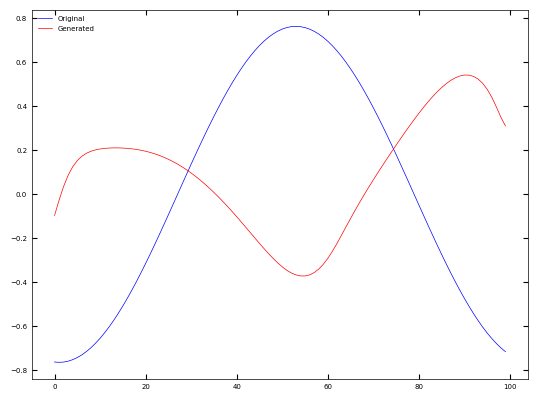

In [26]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


In [27]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


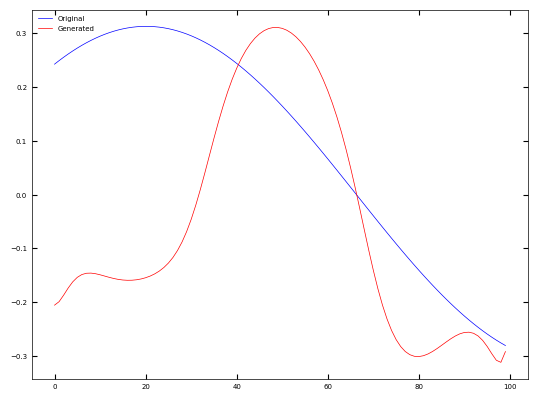

In [28]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


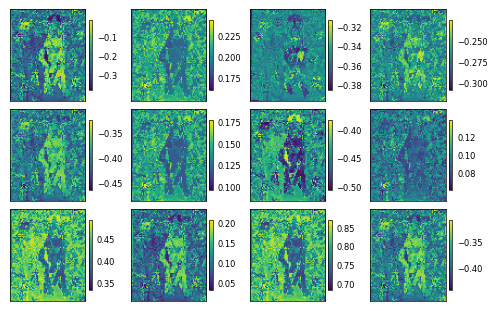

In [29]:
# Visualize the learned embeddings

embeddings(nala_encoded_, shape_=image.shape[0:2], figsize=(5, 3))


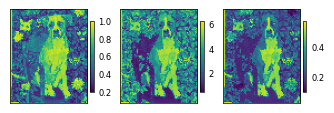

In [30]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(4, 1.25))


In [31]:
class DensePhysLarger(nn.Module):
    def __init__(
        self,
        x_vector,
        model,
        dense_params=3,
        verbose=False,
        device="cuda",
        num_channels=1,
        **kwargs
    ):
        """

        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get("model_params")
        # (self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.model = model
        self.sigmoid = nn.Sigmoid()
        n = 4

        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.num_channels,
                      out_channels=8 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8 * n, out_channels=6 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6 * n, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        self.hidden_x1_shape = self.hidden_x1(
            torch.zeros(1, self.num_channels, self.x_vector.shape[0])
        ).shape

        # fully connected block

        self.hidden_xfc = nn.Sequential(
            nn.Linear(self.hidden_x1_shape[1] * self.hidden_x1_shape[2], 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # out of size 20

        self.hidden_xfc_shape = self.hidden_xfc(
            torch.zeros(1, self.hidden_x1_shape[1] * self.hidden_x1_shape[2])
        ).shape

        # 2nd block of 1d-conv layers

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4 * n, out_channels=2 * n, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2 * n, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        self.hidden_x2_shape = self.hidden_x2(
            torch.zeros(
                (
                    self.hidden_xfc_shape[0],
                    1,
                    self.hidden_x1_shape[1] * self.hidden_x1_shape[2],
                )
            )
        ).shape

        # Flatten layer

        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear

        self.hidden_embedding = nn.Sequential(
            nn.Linear(
                self.hidden_x2_shape[1] * self.hidden_x2_shape[2]
                + self.hidden_xfc_shape[1],
                16,
            ),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.dense_params),
        )

    def forward(self, x, n=-1):

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(
            x, (x.shape[0], 1, self.hidden_x1_shape[1]
                * self.hidden_x1_shape[2])
        )
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.

        embedding = self.hidden_embedding(encoded)  # output is 3 parameters

        embedding = torch.reshape(embedding, (embedding.shape[0], 3, -1))

        embedding[:, 0, :] = (
            embedding[:, 0, :] * self.model.amp_sd + self.model.amp_mean
        )
        embedding[:, 1, :] = (
            embedding[:, 1, :] * self.model.phase_sd + self.model.phase_mean
        )
        embedding[:, 2, :] = (
            embedding[:, 2, :] * self.model.frequency_sd +
            self.model.frequency_mean
        )

        embedding = torch.reshape(embedding, (embedding.shape[0], -1))

        embedding = torch.abs(embedding)
        self.embed = embedding

        (out, _) = self.model.compute(embedding, device=self.device)

        out = torch.transpose(out, 1, 2)
        out = torch.atleast_3d(out)

        return (out.to(self.device), embedding.to(self.device))


In [32]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()


In [33]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)


In [34]:
random_seed(seed=42)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


C:\Conda\envs\tester\lib\site-packages\torch\autograd\__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 0/200, recon loss = 0.34807280
--- 0.2688558101654053 seconds ---
epoch : 1/200, recon loss = 0.33283551
--- 0.19803977012634277 seconds ---


epoch : 2/200, recon loss = 0.31464566
--- 0.20696306228637695 seconds ---
epoch : 3/200, recon loss = 0.29415374
--- 0.19378232955932617 seconds ---


epoch : 4/200, recon loss = 0.27283954
--- 0.19611001014709473 seconds ---
epoch : 5/200, recon loss = 0.25320166
--- 0.1963191032409668 seconds ---


epoch : 6/200, recon loss = 0.23616149
--- 0.2008824348449707 seconds ---
epoch : 7/200, recon loss = 0.22234959
--- 0.18890690803527832 seconds ---


epoch : 8/200, recon loss = 0.21207689
--- 0.20016789436340332 seconds ---


epoch : 9/200, recon loss = 0.20456130
--- 0.20559096336364746 seconds ---
epoch : 10/200, recon loss = 0.19881441
--- 0.1931016445159912 seconds ---


epoch : 11/200, recon loss = 0.19401170
--- 0.20499897003173828 seconds ---


epoch : 12/200, recon loss = 0.18974662
--- 0.202864408493042 seconds ---
epoch : 13/200, recon loss = 0.18563373
--- 0.1911940574645996 seconds ---


epoch : 14/200, recon loss = 0.18159996
--- 0.19503021240234375 seconds ---


epoch : 15/200, recon loss = 0.17750055
--- 0.20202016830444336 seconds ---
epoch : 16/200, recon loss = 0.17329106
--- 0.195054292678833 seconds ---


epoch : 17/200, recon loss = 0.16894082
--- 0.19701886177062988 seconds ---
epoch : 18/200, recon loss = 0.16456736
--- 0.1997835636138916 seconds ---


epoch : 19/200, recon loss = 0.16009169
--- 0.1962144374847412 seconds ---
epoch : 20/200, recon loss = 0.15562698
--- 0.19768929481506348 seconds ---


epoch : 21/200, recon loss = 0.15115488
--- 0.19597220420837402 seconds ---


epoch : 22/200, recon loss = 0.14688887
--- 0.2188701629638672 seconds ---


epoch : 23/200, recon loss = 0.14286481
--- 0.20143342018127441 seconds ---


epoch : 24/200, recon loss = 0.13910449
--- 0.20210766792297363 seconds ---


epoch : 25/200, recon loss = 0.13563611
--- 0.22080612182617188 seconds ---


epoch : 26/200, recon loss = 0.13238615
--- 0.21509122848510742 seconds ---


epoch : 27/200, recon loss = 0.12927848
--- 0.21271657943725586 seconds ---


epoch : 28/200, recon loss = 0.12628385
--- 0.20734786987304688 seconds ---
epoch : 29/200, recon loss = 0.12345168
--- 0.19374442100524902 seconds ---


epoch : 30/200, recon loss = 0.12075605
--- 0.2121264934539795 seconds ---
epoch : 31/200, recon loss = 0.11821032
--- 0.1929645538330078 seconds ---


epoch : 32/200, recon loss = 0.11582141
--- 0.19989776611328125 seconds ---


epoch : 33/200, recon loss = 0.11351594
--- 0.20789361000061035 seconds ---


epoch : 34/200, recon loss = 0.11129579
--- 0.20508313179016113 seconds ---
epoch : 35/200, recon loss = 0.10915355
--- 0.19101428985595703 seconds ---


epoch : 36/200, recon loss = 0.10709315
--- 0.21694254875183105 seconds ---


epoch : 37/200, recon loss = 0.10502782
--- 0.20208334922790527 seconds ---
epoch : 38/200, recon loss = 0.10303617
--- 0.19609689712524414 seconds ---


epoch : 39/200, recon loss = 0.10108129
--- 0.2018575668334961 seconds ---
epoch : 40/200, recon loss = 0.09914659
--- 0.19390439987182617 seconds ---


epoch : 41/200, recon loss = 0.09726178
--- 0.20608735084533691 seconds ---


epoch : 42/200, recon loss = 0.09543975
--- 0.20115447044372559 seconds ---


epoch : 43/200, recon loss = 0.09362761
--- 0.20877504348754883 seconds ---


epoch : 44/200, recon loss = 0.09185290
--- 0.2091836929321289 seconds ---


epoch : 45/200, recon loss = 0.09010732
--- 0.22312116622924805 seconds ---


epoch : 46/200, recon loss = 0.08837237
--- 0.2120821475982666 seconds ---


epoch : 47/200, recon loss = 0.08666587
--- 0.21672892570495605 seconds ---


epoch : 48/200, recon loss = 0.08498020
--- 0.20472145080566406 seconds ---
epoch : 49/200, recon loss = 0.08333856
--- 0.1970062255859375 seconds ---


epoch : 50/200, recon loss = 0.08170116
--- 0.2244420051574707 seconds ---


epoch : 51/200, recon loss = 0.08008867
--- 0.2077314853668213 seconds ---


epoch : 52/200, recon loss = 0.07849357
--- 0.20915484428405762 seconds ---


epoch : 53/200, recon loss = 0.07692593
--- 0.20223069190979004 seconds ---


epoch : 54/200, recon loss = 0.07538773
--- 0.20766162872314453 seconds ---


epoch : 55/200, recon loss = 0.07384971
--- 0.20816588401794434 seconds ---


epoch : 56/200, recon loss = 0.07236687
--- 0.2370147705078125 seconds ---


epoch : 57/200, recon loss = 0.07086872
--- 0.2107400894165039 seconds ---
epoch : 58/200, recon loss = 0.06940658
--- 0.20001816749572754 seconds ---


epoch : 59/200, recon loss = 0.06797616
--- 0.1910696029663086 seconds ---
epoch : 60/200, recon loss = 0.06655420
--- 0.1959848403930664 seconds ---


epoch : 61/200, recon loss = 0.06513228
--- 0.19836163520812988 seconds ---
epoch : 62/200, recon loss = 0.06372215
--- 0.18993782997131348 seconds ---


epoch : 63/200, recon loss = 0.06232392
--- 0.20185232162475586 seconds ---
epoch : 64/200, recon loss = 0.06092052
--- 0.1957075595855713 seconds ---


epoch : 65/200, recon loss = 0.05951931
--- 0.20135927200317383 seconds ---
epoch : 66/200, recon loss = 0.05813025
--- 0.1939692497253418 seconds ---


epoch : 67/200, recon loss = 0.05676346
--- 0.19992446899414062 seconds ---
epoch : 68/200, recon loss = 0.05541770
--- 0.19985151290893555 seconds ---


epoch : 69/200, recon loss = 0.05406192
--- 0.20111083984375 seconds ---
epoch : 70/200, recon loss = 0.05271905
--- 0.19896912574768066 seconds ---


epoch : 71/200, recon loss = 0.05136322
--- 0.21081233024597168 seconds ---
epoch : 72/200, recon loss = 0.05007479
--- 0.197479248046875 seconds ---


epoch : 73/200, recon loss = 0.04885037
--- 0.19659638404846191 seconds ---


epoch : 74/200, recon loss = 0.04767121
--- 0.206251859664917 seconds ---
epoch : 75/200, recon loss = 0.04654971
--- 0.198150634765625 seconds ---


epoch : 76/200, recon loss = 0.04544103
--- 0.18958187103271484 seconds ---
epoch : 77/200, recon loss = 0.04439514
--- 0.1940290927886963 seconds ---


epoch : 78/200, recon loss = 0.04335661
--- 0.1920180320739746 seconds ---
epoch : 79/200, recon loss = 0.04237685
--- 0.19924187660217285 seconds ---


epoch : 80/200, recon loss = 0.04141884
--- 0.19711089134216309 seconds ---
epoch : 81/200, recon loss = 0.04052561
--- 0.19364428520202637 seconds ---


epoch : 82/200, recon loss = 0.03968272
--- 0.1993706226348877 seconds ---
epoch : 83/200, recon loss = 0.03881015
--- 0.19755959510803223 seconds ---


epoch : 84/200, recon loss = 0.03797960
--- 0.2030954360961914 seconds ---


epoch : 85/200, recon loss = 0.03720163
--- 0.20677900314331055 seconds ---
epoch : 86/200, recon loss = 0.03646559
--- 0.19347763061523438 seconds ---


epoch : 87/200, recon loss = 0.03573858
--- 0.19868254661560059 seconds ---
epoch : 88/200, recon loss = 0.03506131
--- 0.19338274002075195 seconds ---


epoch : 89/200, recon loss = 0.03438909
--- 0.2040247917175293 seconds ---
epoch : 90/200, recon loss = 0.03376131
--- 0.19340825080871582 seconds ---


epoch : 91/200, recon loss = 0.03317720
--- 0.19452118873596191 seconds ---


epoch : 92/200, recon loss = 0.03257134
--- 0.20319223403930664 seconds ---


epoch : 93/200, recon loss = 0.03200933
--- 0.20140981674194336 seconds ---


epoch : 94/200, recon loss = 0.03146712
--- 0.20116472244262695 seconds ---


epoch : 95/200, recon loss = 0.03096629
--- 0.20787882804870605 seconds ---
epoch : 96/200, recon loss = 0.03045955
--- 0.19810223579406738 seconds ---


epoch : 97/200, recon loss = 0.02997939
--- 0.19893240928649902 seconds ---


epoch : 98/200, recon loss = 0.02952793
--- 0.20303845405578613 seconds ---
epoch : 99/200, recon loss = 0.02908726
--- 0.19814491271972656 seconds ---


epoch : 100/200, recon loss = 0.02865447
--- 0.2010047435760498 seconds ---
epoch : 101/200, recon loss = 0.02825229
--- 0.19613289833068848 seconds ---


epoch : 102/200, recon loss = 0.02786500
--- 0.20421457290649414 seconds ---


epoch : 103/200, recon loss = 0.02748058
--- 0.20360946655273438 seconds ---


epoch : 104/200, recon loss = 0.02715286
--- 0.21103429794311523 seconds ---
epoch : 105/200, recon loss = 0.02678046
--- 0.19884729385375977 seconds ---


epoch : 106/200, recon loss = 0.02642589
--- 0.20712947845458984 seconds ---


epoch : 107/200, recon loss = 0.02608166
--- 0.2026960849761963 seconds ---
epoch : 108/200, recon loss = 0.02576820
--- 0.19642877578735352 seconds ---


epoch : 109/200, recon loss = 0.02543095
--- 0.19765067100524902 seconds ---
epoch : 110/200, recon loss = 0.02513599
--- 0.19426393508911133 seconds ---


epoch : 111/200, recon loss = 0.02481358
--- 0.20300841331481934 seconds ---


epoch : 112/200, recon loss = 0.02452924
--- 0.20146489143371582 seconds ---


epoch : 113/200, recon loss = 0.02425299
--- 0.20367932319641113 seconds ---


epoch : 114/200, recon loss = 0.02398720
--- 0.20358610153198242 seconds ---


epoch : 115/200, recon loss = 0.02374177
--- 0.20607972145080566 seconds ---


epoch : 116/200, recon loss = 0.02349455
--- 0.21015262603759766 seconds ---


epoch : 117/200, recon loss = 0.02322221
--- 0.20106220245361328 seconds ---
epoch : 118/200, recon loss = 0.02298728
--- 0.19414067268371582 seconds ---


epoch : 119/200, recon loss = 0.02276904
--- 0.1935741901397705 seconds ---
epoch : 120/200, recon loss = 0.02254664
--- 0.19832587242126465 seconds ---


epoch : 121/200, recon loss = 0.02231365
--- 0.20005464553833008 seconds ---
epoch : 122/200, recon loss = 0.02208943
--- 0.19477057456970215 seconds ---


epoch : 123/200, recon loss = 0.02189792
--- 0.1981654167175293 seconds ---
epoch : 124/200, recon loss = 0.02168118
--- 0.18723487854003906 seconds ---


epoch : 125/200, recon loss = 0.02149280
--- 0.20177674293518066 seconds ---
epoch : 126/200, recon loss = 0.02128378
--- 0.19440674781799316 seconds ---


epoch : 127/200, recon loss = 0.02108556
--- 0.20251774787902832 seconds ---
epoch : 128/200, recon loss = 0.02089255
--- 0.19781255722045898 seconds ---


epoch : 129/200, recon loss = 0.02069051
--- 0.1995835304260254 seconds ---
epoch : 130/200, recon loss = 0.02053845
--- 0.1991136074066162 seconds ---


epoch : 131/200, recon loss = 0.02030655
--- 0.19906878471374512 seconds ---
epoch : 132/200, recon loss = 0.02012786
--- 0.1910843849182129 seconds ---


epoch : 133/200, recon loss = 0.01995087
--- 0.193526029586792 seconds ---


epoch : 134/200, recon loss = 0.01977982
--- 0.20143556594848633 seconds ---
epoch : 135/200, recon loss = 0.01965809
--- 0.19618797302246094 seconds ---


epoch : 136/200, recon loss = 0.01950948
--- 0.22810769081115723 seconds ---


epoch : 137/200, recon loss = 0.01932105
--- 0.21117877960205078 seconds ---


epoch : 138/200, recon loss = 0.01917399
--- 0.20613813400268555 seconds ---


epoch : 139/200, recon loss = 0.01906718
--- 0.21146273612976074 seconds ---


epoch : 140/200, recon loss = 0.01887016
--- 0.2053534984588623 seconds ---


epoch : 141/200, recon loss = 0.01872706
--- 0.20202374458312988 seconds ---


epoch : 142/200, recon loss = 0.01857432
--- 0.20783543586730957 seconds ---


epoch : 143/200, recon loss = 0.01839714
--- 0.2030928134918213 seconds ---
epoch : 144/200, recon loss = 0.01827038
--- 0.1949145793914795 seconds ---


epoch : 145/200, recon loss = 0.01813872
--- 0.19809412956237793 seconds ---


epoch : 146/200, recon loss = 0.01797835
--- 0.20172595977783203 seconds ---
epoch : 147/200, recon loss = 0.01784135
--- 0.19411158561706543 seconds ---


epoch : 148/200, recon loss = 0.01771266
--- 0.19808268547058105 seconds ---
epoch : 149/200, recon loss = 0.01758356
--- 0.19999146461486816 seconds ---


epoch : 150/200, recon loss = 0.01747303
--- 0.19305944442749023 seconds ---
epoch : 151/200, recon loss = 0.01734831
--- 0.19490265846252441 seconds ---


epoch : 152/200, recon loss = 0.01718911
--- 0.19733357429504395 seconds ---


epoch : 153/200, recon loss = 0.01706397
--- 0.20481491088867188 seconds ---
epoch : 154/200, recon loss = 0.01690293
--- 0.19399714469909668 seconds ---


epoch : 155/200, recon loss = 0.01675163
--- 0.1930530071258545 seconds ---
epoch : 156/200, recon loss = 0.01660447
--- 0.18873357772827148 seconds ---


epoch : 157/200, recon loss = 0.01643399
--- 0.18406009674072266 seconds ---
epoch : 158/200, recon loss = 0.01629251
--- 0.18918776512145996 seconds ---


epoch : 159/200, recon loss = 0.01610098
--- 0.20866107940673828 seconds ---


epoch : 160/200, recon loss = 0.01598646
--- 0.20232462882995605 seconds ---


epoch : 161/200, recon loss = 0.01580715
--- 0.20209288597106934 seconds ---
epoch : 162/200, recon loss = 0.01569014
--- 0.19696307182312012 seconds ---


epoch : 163/200, recon loss = 0.01557551
--- 0.19694066047668457 seconds ---
epoch : 164/200, recon loss = 0.01545451
--- 0.19886064529418945 seconds ---


epoch : 165/200, recon loss = 0.01538321
--- 0.20408010482788086 seconds ---
epoch : 166/200, recon loss = 0.01524637
--- 0.196974515914917 seconds ---


epoch : 167/200, recon loss = 0.01517115
--- 0.190903902053833 seconds ---


epoch : 168/200, recon loss = 0.01508343
--- 0.20600080490112305 seconds ---
epoch : 169/200, recon loss = 0.01499243
--- 0.1983036994934082 seconds ---


epoch : 170/200, recon loss = 0.01487488
--- 0.18999099731445312 seconds ---


epoch : 171/200, recon loss = 0.01479703
--- 0.20377707481384277 seconds ---
epoch : 172/200, recon loss = 0.01470177
--- 0.19924306869506836 seconds ---


epoch : 173/200, recon loss = 0.01464055
--- 0.19683527946472168 seconds ---
epoch : 174/200, recon loss = 0.01455038
--- 0.19982504844665527 seconds ---


epoch : 175/200, recon loss = 0.01447237
--- 0.19820666313171387 seconds ---


epoch : 176/200, recon loss = 0.01439379
--- 0.20581531524658203 seconds ---


epoch : 177/200, recon loss = 0.01432416
--- 0.20508074760437012 seconds ---


epoch : 178/200, recon loss = 0.01423361
--- 0.20488834381103516 seconds ---


epoch : 179/200, recon loss = 0.01415041
--- 0.21409106254577637 seconds ---
epoch : 180/200, recon loss = 0.01409452
--- 0.19497990608215332 seconds ---


epoch : 181/200, recon loss = 0.01409764
--- 0.1998591423034668 seconds ---


epoch : 182/200, recon loss = 0.01394408
--- 0.22314715385437012 seconds ---


epoch : 183/200, recon loss = 0.01384625
--- 0.20988225936889648 seconds ---
epoch : 184/200, recon loss = 0.01377149
--- 0.19437360763549805 seconds ---


epoch : 185/200, recon loss = 0.01372932
--- 0.21680092811584473 seconds ---
epoch : 186/200, recon loss = 0.01362960
--- 0.1980452537536621 seconds ---


epoch : 187/200, recon loss = 0.01353948
--- 0.1931474208831787 seconds ---
epoch : 188/200, recon loss = 0.01353349
--- 0.1821129322052002 seconds ---


epoch : 189/200, recon loss = 0.01338859
--- 0.18354249000549316 seconds ---
epoch : 190/200, recon loss = 0.01332263
--- 0.19216632843017578 seconds ---


epoch : 191/200, recon loss = 0.01327185
--- 0.19812273979187012 seconds ---


epoch : 192/200, recon loss = 0.01320056
--- 0.21071243286132812 seconds ---


epoch : 193/200, recon loss = 0.01314720
--- 0.22427630424499512 seconds ---


epoch : 194/200, recon loss = 0.01306704
--- 0.2137911319732666 seconds ---
epoch : 195/200, recon loss = 0.01308356
--- 0.19309473037719727 seconds ---


epoch : 196/200, recon loss = 0.01293651
--- 0.19423246383666992 seconds ---
epoch : 197/200, recon loss = 0.01287104
--- 0.19859838485717773 seconds ---


epoch : 198/200, recon loss = 0.01280888
--- 0.20104694366455078 seconds ---


epoch : 199/200, recon loss = 0.01277112
--- 0.21419596672058105 seconds ---


tensor([0.4922, 1.7016, 0.4067], device='cuda:0', grad_fn=<SelectBackward0>)


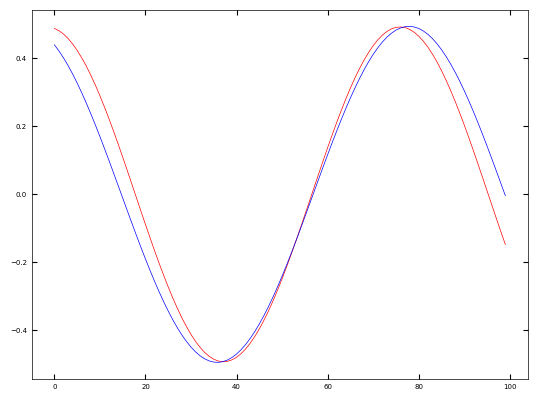

In [35]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


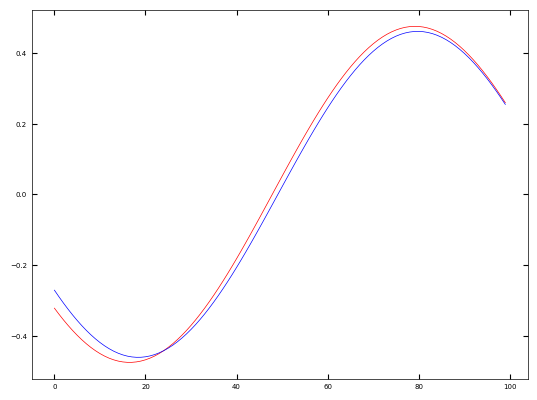

In [36]:
nala_spectra_generated, nala_params = model(
    nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [37]:
# removes 2pi shifts
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


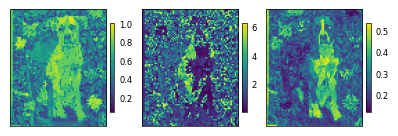

In [38]:
# Visualize the learned embeddings
embeddings(nala_params.detach().cpu().numpy(),
           shape_=image.shape[0:2], figsize=(5, 1.25))


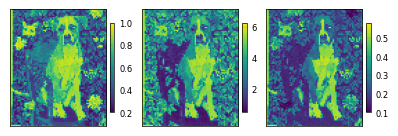

In [39]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))


In [40]:
"""
Created on Sun Feb 26 16:34:00 2021
@author: Amir Gholami
@coauthor: David Samuel
"""

import numpy as np
import torch


class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(
        self,
        params,
        lr=0.1,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0.0,
        hessian_power=1.0,
        update_each=1,
        n_samples=1,
        average_conv_kernel=False,
    ):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            hessian_power=hessian_power,
        )
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (
            p for group in self.param_groups for p in group["params"] if p.requires_grad
        )

    def zero_hessian(self):
        """
        Zeros out the accumulated hessian traces.
        """

        for p in self.get_params():
            if (
                not isinstance(p.hess, float)
                and self.state[p]["hessian step"] % self.update_each == 0
            ):
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if (
                self.state[p]["hessian step"] % self.update_each == 0
            ):  # compute the trace only for each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if (
            self.generator.device != params[0].device
        ):  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(
                params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [
                torch.randint(0, 2, p.size(),
                              generator=self.generator, device=p.device)
                * 2.0
                - 1.0
                for p in params
            ]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(
                grads,
                params,
                grad_outputs=zs,
                only_inputs=True,
                retain_graph=i < self.n_samples - 1,
            )
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += (
                    h_z * z / self.n_samples
                )  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = (
                        torch.abs(p.hess)
                        .mean(dim=[2, 3], keepdim=True)
                        .expand_as(p.hess)
                        .clone()
                    )

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group["lr"] * group["weight_decay"])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of gradient values
                    state["exp_hessian_diag_sq"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = (
                    state["exp_avg"],
                    state["exp_hessian_diag_sq"],
                )
                beta1, beta2 = group["betas"]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(
                    p.hess, p.hess, value=1 - beta2
                )

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                k = group["hessian_power"]
                denom = (
                    (exp_hessian_diag_sq / bias_correction2)
                    .pow_(k / 2)
                    .add_(group["eps"])
                )

                # make update
                step_size = group["lr"] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss


In [41]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()


In [42]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)


In [43]:
random_seed(seed=42)

loss_func = torch.nn.MSELoss()

# Use AdaHessian

optimizer = AdaHessian(model.parameters(), lr=0.1)

epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


epoch : 0/200, recon loss = 0.17086771
--- 0.992203950881958 seconds ---


epoch : 1/200, recon loss = 0.11368242
--- 0.9979922771453857 seconds ---


epoch : 2/200, recon loss = 0.09149935
--- 1.0052542686462402 seconds ---


epoch : 3/200, recon loss = 0.08109332
--- 1.0119173526763916 seconds ---


epoch : 4/200, recon loss = 0.07300402
--- 0.9887223243713379 seconds ---


epoch : 5/200, recon loss = 0.06154821
--- 0.9880692958831787 seconds ---


epoch : 6/200, recon loss = 0.04481230
--- 1.005181074142456 seconds ---


epoch : 7/200, recon loss = 0.03363199
--- 1.0261585712432861 seconds ---


epoch : 8/200, recon loss = 0.02759685
--- 0.9979438781738281 seconds ---


epoch : 9/200, recon loss = 0.02423186
--- 0.9906377792358398 seconds ---


epoch : 10/200, recon loss = 0.02235563
--- 0.9803910255432129 seconds ---


epoch : 11/200, recon loss = 0.02064108
--- 0.9951779842376709 seconds ---


epoch : 12/200, recon loss = 0.02013041
--- 1.0024144649505615 seconds ---


epoch : 13/200, recon loss = 0.01872475
--- 0.9780595302581787 seconds ---


epoch : 14/200, recon loss = 0.01762000
--- 1.0028491020202637 seconds ---


epoch : 15/200, recon loss = 0.01710001
--- 1.018540382385254 seconds ---


epoch : 16/200, recon loss = 0.01665186
--- 1.0074999332427979 seconds ---


epoch : 17/200, recon loss = 0.01564300
--- 1.0169892311096191 seconds ---


epoch : 18/200, recon loss = 0.01527037
--- 1.0154967308044434 seconds ---


epoch : 19/200, recon loss = 0.01471946
--- 0.9885673522949219 seconds ---


epoch : 20/200, recon loss = 0.01429902
--- 0.9954454898834229 seconds ---


epoch : 21/200, recon loss = 0.01397184
--- 0.9948124885559082 seconds ---


epoch : 22/200, recon loss = 0.01460770
--- 1.0848286151885986 seconds ---


epoch : 23/200, recon loss = 0.01380353
--- 1.0221214294433594 seconds ---


epoch : 24/200, recon loss = 0.01325056
--- 1.018131971359253 seconds ---


epoch : 25/200, recon loss = 0.01299828
--- 1.026688575744629 seconds ---


epoch : 26/200, recon loss = 0.01269517
--- 0.991884708404541 seconds ---


epoch : 27/200, recon loss = 0.01283471
--- 1.0023460388183594 seconds ---


epoch : 28/200, recon loss = 0.01228550
--- 1.0120861530303955 seconds ---


epoch : 29/200, recon loss = 0.01207417
--- 1.0056521892547607 seconds ---


epoch : 30/200, recon loss = 0.01161719
--- 1.0083274841308594 seconds ---


epoch : 31/200, recon loss = 0.01151281
--- 1.001061201095581 seconds ---


epoch : 32/200, recon loss = 0.01142093
--- 1.0264499187469482 seconds ---


epoch : 33/200, recon loss = 0.01118099
--- 0.9831898212432861 seconds ---


epoch : 34/200, recon loss = 0.01116415
--- 0.9812774658203125 seconds ---


epoch : 35/200, recon loss = 0.01075662
--- 1.0010311603546143 seconds ---


epoch : 36/200, recon loss = 0.01181210
--- 0.9980816841125488 seconds ---


epoch : 37/200, recon loss = 0.01110685
--- 0.9846549034118652 seconds ---


epoch : 38/200, recon loss = 0.01061795
--- 0.9792585372924805 seconds ---


epoch : 39/200, recon loss = 0.01017559
--- 0.9717788696289062 seconds ---


epoch : 40/200, recon loss = 0.01040016
--- 0.9850060939788818 seconds ---


epoch : 41/200, recon loss = 0.00988642
--- 1.0072548389434814 seconds ---


epoch : 42/200, recon loss = 0.00968805
--- 0.9869613647460938 seconds ---


epoch : 43/200, recon loss = 0.00986370
--- 0.9987986087799072 seconds ---


epoch : 44/200, recon loss = 0.00977156
--- 0.9751002788543701 seconds ---


epoch : 45/200, recon loss = 0.00966532
--- 0.9939754009246826 seconds ---


epoch : 46/200, recon loss = 0.00920948
--- 1.0069875717163086 seconds ---


epoch : 47/200, recon loss = 0.00902075
--- 0.9869406223297119 seconds ---


epoch : 48/200, recon loss = 0.00911982
--- 0.969895601272583 seconds ---


epoch : 49/200, recon loss = 0.00898608
--- 0.9921514987945557 seconds ---


epoch : 50/200, recon loss = 0.00861503
--- 0.9977207183837891 seconds ---


epoch : 51/200, recon loss = 0.00857300
--- 0.9776437282562256 seconds ---


epoch : 52/200, recon loss = 0.00850108
--- 0.973973274230957 seconds ---


epoch : 53/200, recon loss = 0.00829468
--- 0.9798104763031006 seconds ---


epoch : 54/200, recon loss = 0.00896686
--- 0.9784350395202637 seconds ---


epoch : 55/200, recon loss = 0.00857166
--- 0.9763326644897461 seconds ---


epoch : 56/200, recon loss = 0.00823798
--- 0.9700078964233398 seconds ---


epoch : 57/200, recon loss = 0.00817007
--- 0.9780535697937012 seconds ---


epoch : 58/200, recon loss = 0.00817124
--- 0.9831407070159912 seconds ---


epoch : 59/200, recon loss = 0.00788201
--- 0.9777102470397949 seconds ---


epoch : 60/200, recon loss = 0.00837781
--- 0.9719991683959961 seconds ---


epoch : 61/200, recon loss = 0.00784082
--- 0.9849700927734375 seconds ---


epoch : 62/200, recon loss = 0.00791794
--- 0.9863324165344238 seconds ---


epoch : 63/200, recon loss = 0.00764476
--- 0.9859871864318848 seconds ---


epoch : 64/200, recon loss = 0.00762514
--- 0.998953104019165 seconds ---


epoch : 65/200, recon loss = 0.00739705
--- 0.9811069965362549 seconds ---


epoch : 66/200, recon loss = 0.00733416
--- 0.9890985488891602 seconds ---


epoch : 67/200, recon loss = 0.00784876
--- 0.9736089706420898 seconds ---


epoch : 68/200, recon loss = 0.00776997
--- 0.9753725528717041 seconds ---


epoch : 69/200, recon loss = 0.00819303
--- 0.9915919303894043 seconds ---


epoch : 70/200, recon loss = 0.00763240
--- 0.9736373424530029 seconds ---


epoch : 71/200, recon loss = 0.00723609
--- 0.9863128662109375 seconds ---


epoch : 72/200, recon loss = 0.00719336
--- 0.9993200302124023 seconds ---


epoch : 73/200, recon loss = 0.00774331
--- 0.9765305519104004 seconds ---


epoch : 74/200, recon loss = 0.00843049
--- 0.9791581630706787 seconds ---


epoch : 75/200, recon loss = 0.00840651
--- 1.01078462600708 seconds ---


epoch : 76/200, recon loss = 0.00808620
--- 0.9836277961730957 seconds ---


epoch : 77/200, recon loss = 0.00811279
--- 0.9778947830200195 seconds ---


epoch : 78/200, recon loss = 0.00767359
--- 0.992133617401123 seconds ---


epoch : 79/200, recon loss = 0.00779992
--- 1.005643367767334 seconds ---


epoch : 80/200, recon loss = 0.00762372
--- 1.0041418075561523 seconds ---


epoch : 81/200, recon loss = 0.00741630
--- 0.9861478805541992 seconds ---


epoch : 82/200, recon loss = 0.00725202
--- 1.0023930072784424 seconds ---


epoch : 83/200, recon loss = 0.00713074
--- 1.0072438716888428 seconds ---


epoch : 84/200, recon loss = 0.00717635
--- 1.005155086517334 seconds ---


epoch : 85/200, recon loss = 0.00723294
--- 1.013742446899414 seconds ---


epoch : 86/200, recon loss = 0.00706804
--- 0.9889919757843018 seconds ---


epoch : 87/200, recon loss = 0.00711016
--- 1.0005407333374023 seconds ---


epoch : 88/200, recon loss = 0.00698168
--- 0.9955096244812012 seconds ---


epoch : 89/200, recon loss = 0.00722560
--- 1.0121452808380127 seconds ---


epoch : 90/200, recon loss = 0.00686488
--- 0.9880995750427246 seconds ---


epoch : 91/200, recon loss = 0.00699882
--- 1.0125222206115723 seconds ---


epoch : 92/200, recon loss = 0.00671915
--- 0.9935829639434814 seconds ---


epoch : 93/200, recon loss = 0.00651175
--- 1.0021452903747559 seconds ---


epoch : 94/200, recon loss = 0.00657456
--- 0.9899053573608398 seconds ---


epoch : 95/200, recon loss = 0.00648801
--- 0.9900290966033936 seconds ---


epoch : 96/200, recon loss = 0.00638434
--- 1.0200371742248535 seconds ---


epoch : 97/200, recon loss = 0.00649289
--- 0.9947397708892822 seconds ---


epoch : 98/200, recon loss = 0.00631681
--- 0.9969890117645264 seconds ---


epoch : 99/200, recon loss = 0.00633504
--- 0.993152379989624 seconds ---


epoch : 100/200, recon loss = 0.00621473
--- 0.9999985694885254 seconds ---


epoch : 101/200, recon loss = 0.00614486
--- 0.9989352226257324 seconds ---


epoch : 102/200, recon loss = 0.00610717
--- 1.0007190704345703 seconds ---


epoch : 103/200, recon loss = 0.00663451
--- 1.017409086227417 seconds ---


epoch : 104/200, recon loss = 0.00631396
--- 1.0048272609710693 seconds ---


epoch : 105/200, recon loss = 0.00594270
--- 0.9987711906433105 seconds ---


epoch : 106/200, recon loss = 0.00618116
--- 1.0231757164001465 seconds ---


epoch : 107/200, recon loss = 0.00621261
--- 1.0061378479003906 seconds ---


epoch : 108/200, recon loss = 0.00639126
--- 0.988755464553833 seconds ---


epoch : 109/200, recon loss = 0.00605313
--- 0.986098051071167 seconds ---


epoch : 110/200, recon loss = 0.00590520
--- 0.9902286529541016 seconds ---


epoch : 111/200, recon loss = 0.00582665
--- 0.9969298839569092 seconds ---


epoch : 112/200, recon loss = 0.00578627
--- 0.9869260787963867 seconds ---


epoch : 113/200, recon loss = 0.00567832
--- 0.9907464981079102 seconds ---


epoch : 114/200, recon loss = 0.00551208
--- 1.009021282196045 seconds ---


epoch : 115/200, recon loss = 0.00542893
--- 0.9800155162811279 seconds ---


epoch : 116/200, recon loss = 0.00550339
--- 0.9800972938537598 seconds ---


epoch : 117/200, recon loss = 0.00578331
--- 0.9800894260406494 seconds ---


epoch : 118/200, recon loss = 0.00620850
--- 0.9879977703094482 seconds ---


epoch : 119/200, recon loss = 0.00569097
--- 0.9779291152954102 seconds ---


epoch : 120/200, recon loss = 0.00563444
--- 0.9801468849182129 seconds ---


epoch : 121/200, recon loss = 0.00545037
--- 0.981898307800293 seconds ---


epoch : 122/200, recon loss = 0.00550156
--- 0.9979190826416016 seconds ---


epoch : 123/200, recon loss = 0.00537145
--- 0.9893062114715576 seconds ---


epoch : 124/200, recon loss = 0.00533223
--- 0.9816141128540039 seconds ---


epoch : 125/200, recon loss = 0.00579251
--- 0.9904093742370605 seconds ---


epoch : 126/200, recon loss = 0.00525404
--- 0.9819974899291992 seconds ---


epoch : 127/200, recon loss = 0.00501938
--- 0.9938685894012451 seconds ---


epoch : 128/200, recon loss = 0.00537602
--- 0.9911761283874512 seconds ---


epoch : 129/200, recon loss = 0.00517422
--- 0.9906585216522217 seconds ---


epoch : 130/200, recon loss = 0.00539471
--- 1.07308030128479 seconds ---


epoch : 131/200, recon loss = 0.00561129
--- 0.9882125854492188 seconds ---


epoch : 132/200, recon loss = 0.00547503
--- 1.0338165760040283 seconds ---


epoch : 133/200, recon loss = 0.00542785
--- 1.0038986206054688 seconds ---


epoch : 134/200, recon loss = 0.00506048
--- 1.0301353931427002 seconds ---


epoch : 135/200, recon loss = 0.00531709
--- 1.064704179763794 seconds ---


epoch : 136/200, recon loss = 0.00506606
--- 1.0638229846954346 seconds ---


epoch : 137/200, recon loss = 0.00509699
--- 1.086439609527588 seconds ---


epoch : 138/200, recon loss = 0.00511519
--- 1.0001275539398193 seconds ---


epoch : 139/200, recon loss = 0.00503601
--- 0.9898664951324463 seconds ---


epoch : 140/200, recon loss = 0.00481499
--- 0.9908447265625 seconds ---


epoch : 141/200, recon loss = 0.00484126
--- 0.9862468242645264 seconds ---


epoch : 142/200, recon loss = 0.00494443
--- 1.0836176872253418 seconds ---


epoch : 143/200, recon loss = 0.00491251
--- 1.018296718597412 seconds ---


epoch : 144/200, recon loss = 0.00477069
--- 0.9966268539428711 seconds ---


epoch : 145/200, recon loss = 0.00476796
--- 0.9834203720092773 seconds ---


epoch : 146/200, recon loss = 0.00476252
--- 0.9827535152435303 seconds ---


epoch : 147/200, recon loss = 0.00456319
--- 0.9749984741210938 seconds ---


epoch : 148/200, recon loss = 0.00479492
--- 0.9903416633605957 seconds ---


epoch : 149/200, recon loss = 0.00470143
--- 0.9968304634094238 seconds ---


epoch : 150/200, recon loss = 0.00484542
--- 0.9949774742126465 seconds ---


epoch : 151/200, recon loss = 0.00450357
--- 1.0389089584350586 seconds ---


epoch : 152/200, recon loss = 0.00475943
--- 1.3459560871124268 seconds ---


epoch : 153/200, recon loss = 0.00459987
--- 1.1041457653045654 seconds ---


epoch : 154/200, recon loss = 0.00457904
--- 1.1055166721343994 seconds ---


epoch : 155/200, recon loss = 0.00444959
--- 1.0600700378417969 seconds ---


epoch : 156/200, recon loss = 0.00455763
--- 1.167052984237671 seconds ---


epoch : 157/200, recon loss = 0.00452685
--- 1.0993177890777588 seconds ---


epoch : 158/200, recon loss = 0.00474203
--- 1.0219841003417969 seconds ---


epoch : 159/200, recon loss = 0.00490580
--- 0.9910993576049805 seconds ---


epoch : 160/200, recon loss = 0.00454986
--- 0.9787533283233643 seconds ---


epoch : 161/200, recon loss = 0.00445178
--- 0.973231315612793 seconds ---


epoch : 162/200, recon loss = 0.00444012
--- 0.9737672805786133 seconds ---


epoch : 163/200, recon loss = 0.00443831
--- 1.0192325115203857 seconds ---


epoch : 164/200, recon loss = 0.00430911
--- 0.9900534152984619 seconds ---


epoch : 165/200, recon loss = 0.00456668
--- 0.9637606143951416 seconds ---


epoch : 166/200, recon loss = 0.00454807
--- 0.9812304973602295 seconds ---


epoch : 167/200, recon loss = 0.00414894
--- 0.9868373870849609 seconds ---


epoch : 168/200, recon loss = 0.00414155
--- 1.1662647724151611 seconds ---


epoch : 169/200, recon loss = 0.00424122
--- 0.9729626178741455 seconds ---


epoch : 170/200, recon loss = 0.00409631
--- 0.9835946559906006 seconds ---


epoch : 171/200, recon loss = 0.00411842
--- 0.9792454242706299 seconds ---


epoch : 172/200, recon loss = 0.00437785
--- 0.9808776378631592 seconds ---


epoch : 173/200, recon loss = 0.00443486
--- 0.9752802848815918 seconds ---


epoch : 174/200, recon loss = 0.00442231
--- 0.9858238697052002 seconds ---


epoch : 175/200, recon loss = 0.00422751
--- 0.9731199741363525 seconds ---


epoch : 176/200, recon loss = 0.00399990
--- 0.9673006534576416 seconds ---


epoch : 177/200, recon loss = 0.00403784
--- 0.9745042324066162 seconds ---


epoch : 178/200, recon loss = 0.00428581
--- 0.9857027530670166 seconds ---


epoch : 179/200, recon loss = 0.00419924
--- 0.9747860431671143 seconds ---


epoch : 180/200, recon loss = 0.00434203
--- 0.9875762462615967 seconds ---


epoch : 181/200, recon loss = 0.00402339
--- 0.9770586490631104 seconds ---


epoch : 182/200, recon loss = 0.00411854
--- 0.9827914237976074 seconds ---


epoch : 183/200, recon loss = 0.00484298
--- 0.961972713470459 seconds ---


epoch : 184/200, recon loss = 0.00473085
--- 0.9829933643341064 seconds ---


epoch : 185/200, recon loss = 0.00456008
--- 0.9819905757904053 seconds ---


epoch : 186/200, recon loss = 0.00441936
--- 0.9650595188140869 seconds ---


epoch : 187/200, recon loss = 0.00449378
--- 0.9802234172821045 seconds ---


epoch : 188/200, recon loss = 0.00462792
--- 0.9880788326263428 seconds ---


epoch : 189/200, recon loss = 0.00474576
--- 0.9788672924041748 seconds ---


epoch : 190/200, recon loss = 0.00454052
--- 0.9601485729217529 seconds ---


epoch : 191/200, recon loss = 0.00429006
--- 0.968512773513794 seconds ---


epoch : 192/200, recon loss = 0.00428509
--- 0.9851136207580566 seconds ---


epoch : 193/200, recon loss = 0.00464296
--- 0.9752671718597412 seconds ---


epoch : 194/200, recon loss = 0.00454146
--- 0.9709076881408691 seconds ---


epoch : 195/200, recon loss = 0.00455267
--- 0.9756948947906494 seconds ---


epoch : 196/200, recon loss = 0.00415832
--- 0.9775199890136719 seconds ---


epoch : 197/200, recon loss = 0.00422140
--- 0.9935331344604492 seconds ---


epoch : 198/200, recon loss = 0.00414362
--- 0.9931457042694092 seconds ---


epoch : 199/200, recon loss = 0.00439274
--- 1.0050544738769531 seconds ---


tensor([0.5203, 2.0699, 0.3764], device='cuda:0', grad_fn=<SelectBackward0>)


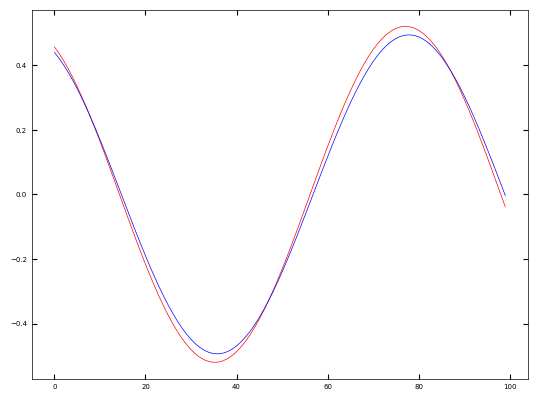

In [44]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


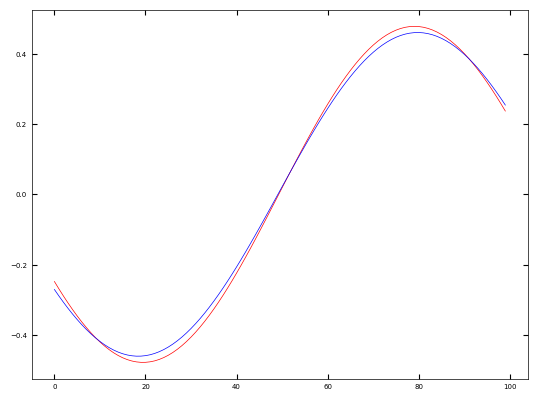

In [45]:
nala_spectra_generated, nala_params = model(
    nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [46]:
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


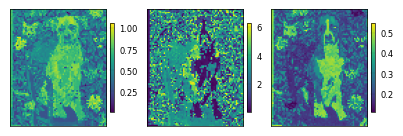

In [47]:
# Visualize the learned embeddings
embeddings(nala_params.detach().cpu().numpy(),
           shape_=image.shape[0:2], figsize=(5, 1.25))


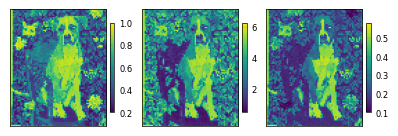

In [48]:
# visualize the actual RGB channels.
embeddings(_nala_params.reshape(-1, 3),
           shape_=image.shape[0:2], figsize=(5, 1.25))
